# Mysterious Fitbit Data

## Project Planning
### Goal:
The goal is to figure out who's Fitbit data this is and to predict what a certain three week span in December would look like for this individual.

### Deliverables: 
- A summarization of the data.
- Predictions for the missing three weeks worth of data in a separate csv file.
- Two slides that can be shared with a general audience. Include at least one visualization, and make sure that the visualization is clearly labeled.
- A notebook containing your analysis, i.e. the work that you did to get to the conclusions and predictions mentioned above.
- A tidied data set. Your notebook should include the code to go from the original source data to a data set that you can work with.

### Data Dictionary:
- calories_burned: The number of calories burned that day
- steps: The number of steps taken that day
- distance: The distance walked that day (assumed to be in miles)
- floors: Number of floors climbed (10 feet in elevation gain = 1 floor)
- minutes_sedentary: Minutes spent not moving or barely moving
- minutes_lightly_active: Minutes spent moving a little bit
- minutes_fairly_active: Minutes spent moving a fair bit (maybe walking)
- minutes_very_active: Minutes spent moving a lot (exercising)
- activity_calories: The number of calories burned during an activity
- calories: Number of calories conumed
- fat (g): Amount of fat consumed
- fiber (g): Amount of fiber consumed
- carbs (g): Amount of carbs consumed
- sodium (mg): Amount of sodium consumed
- protein (g): Amount of protein consumed
- water (fl oz): Amount of water drank
- total_minutes: Total number of minutes of the day that the Fitbit tracked
- day_of_week: Day of the week
- weekend_or_weekday: Weekend or weekday
- bmr: Basal metabolic rate, calculated as the difference between calories consumed and activity calories
- hours_awake: Hours of the day spent awake, calculated by dividing total minutes by 24
- hours_asleep: Hours of the day spent asleep, calculated by subtracting hours awake from 24

### Brainstorming/Hypotheses:
##### Who can this data belong to?
It can belong to a staff member or a participant in an experiment. It is hard to say before looking at the data. However, after an initial glance at data, our hypothesis is that the individual will be a staff member.

##### What can help determine if the individual is a staff member or a participant?
- The way time is spent in terms of activity can be highly relevant. Someone at an office job will be very sedentary while someone in a fitness experiment will move a lot.
- Perhaps food logs will give some insight as well. Eating more or less on certain days? What are they eating?

## Data Acquisition

### Imports

In [1]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

### Pulling in the .csv data

In [2]:
may = pd.read_csv('2018-04-26_through_2018-05-26.csv', sep='\t')
june = pd.read_csv('2018-05-27_through_2018-06-26.csv', sep='\t')
july = pd.read_csv('2018-06-27_through_2018-07-27.csv', sep='\t')
august = pd.read_csv('2018-07-28_through_2018-08-26.csv', sep='\t')
september = pd.read_csv('2018-08-27_through_2018-09-26.csv', sep='\t')
october = pd.read_csv('2018-09-27_through_2018-10-27.csv', sep='\t')
november = pd.read_csv('2018-10-28_through-2018-11-27.csv', sep='\t')
december = pd.read_csv('2018-11-28_through_2018-12-28.csv', sep='\t')

### Building the functions required to have a tidy data set.

In [3]:
# Dropping food log rows that disrupt the functions. 
# Consider keeping them in another column in case it is relevant information.
def drop_rows():
    june.drop(range(102, 107), inplace=True)
    june.reset_index(inplace=True, drop=True)
    november.drop(range(120, 133), inplace=True)
    november.drop(range(142, 156), inplace=True)
    november.drop(range(165, 178), inplace=True)
    november.drop(range(187, 190), inplace=True)
    november.drop(range(199, 208), inplace=True)
    november.drop(range(226, 233), inplace=True)
    november.drop(range(242, 258), inplace=True)
    november.reset_index(inplace=True, drop=True)

def calories_in_dataframe(df, start, finish):
    """Returns a DataFrame of dates and calories consumed."""
    date = []
    calories_in = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
        date.append(i[0])
    #     print(date)
        calories_in.append(i[1])
    #     print(calories_in)
    date_calories_in = pd.DataFrame({'date':date, 'calories_in':calories_in})
    return date_calories_in

def fitness_data_dataframe(df, start, finish):
    """Returns a DataFrame of fitness data."""
    date = []
    cals_burned = []
    steps = []
    dist = []
    floors = []
    sedentary = []
    lightly_active = []
    fairly_active = []
    very_active = []
    activity_calories = []
    for i in df.Foods.loc[start:finish].str.split(',"'):
#         date.append(i[0])
        cals_burned.append(i[1])
        steps.append(i[2])
        dist.append(i[3])
        floors.append(i[4])
        sedentary.append(i[5])
        lightly_active.append(i[6])
        fairly_active.append(i[7])
        very_active.append(i[8])
        activity_calories.append(i[9])
    fitness_data = pd.DataFrame({'calories_burned':cals_burned, 'steps':steps, # date removed
                             'distance':dist, 'floors':floors, 'minutes_sedentary':sedentary, 
                             'minutes_lightly_active':lightly_active, 
                             'minutes_fairly_active':fairly_active, 
                             'minutes_very_active':very_active, 'activity_calories':activity_calories})   
    
    return fitness_data

def make_log_columns(df, column_name, row_to_start_at):
    """Used to make logs DataFrame. Goes through each log and grabs the required data."""
    for i in df.Foods.loc[row_to_start_at::9].str.split(',"'):
        column_name.append(i[2])

def logs_dataframe(df, first_calories_log):
    """Returns a DataFrame of log data."""
    calories = []
    make_log_columns(df, calories, first_calories_log)
    fat = []
    make_log_columns(df, fat, first_calories_log+1)
    fiber = []
    make_log_columns(df, fiber, first_calories_log+2)
    carbs = []
    make_log_columns(df, carbs, first_calories_log+3)
    sodium = []
    make_log_columns(df, sodium, first_calories_log+4)
    protein = []
    make_log_columns(df, protein, first_calories_log+5)
    water = []
    make_log_columns(df, water, first_calories_log+6)
    
    may_logs = pd.DataFrame({'calories':calories, 'fat (g)':fat, 'fiber (g)':fiber, 'carbs (g)':carbs, 
                             'sodium (mg)':sodium, 'protein (g)':protein, 'water (fl oz)':water})
    
    return may_logs

def create_month_dataframe(df, cals_start, cals_finish, fitness_start, fitness_finish, calories_log_start):
    calories_df = calories_in_dataframe(df=df, start=cals_start, finish=cals_finish)
    fitness_df = fitness_data_dataframe(df=df, start=fitness_start, finish=fitness_finish)
    logs_df = logs_dataframe(df=df, first_calories_log=calories_log_start)
    month_df = pd.concat([calories_df, fitness_df, logs_df], axis=1)
    return month_df

def create_all_dataframes():
    may_df = create_month_dataframe(may, 1, 31, 34, 64, 67)
    june_df = create_month_dataframe(june, 1, 31, 34, 64, 67) # need to delete rows 102 through 106
    july_df = create_month_dataframe(july, 1, 31, 34, 64, 67)
    august_df = create_month_dataframe(august, 1, 30, 33, 62, 65) # one less day, need to adjust
    september_df = create_month_dataframe(september, 1, 31, 34, 64, 67)
    october_df = create_month_dataframe(october, 1, 31, 34, 64, 67)
    november_df = create_month_dataframe(november, 1, 31, 34, 64, 67) # need to delete multiple rows
    december_df = create_month_dataframe(december, 1, 31, 34, 42, 45) # fitness data doesn't have full range of days
    return may_df, june_df, july_df, august_df, september_df, october_df, november_df, december_df
    
def string_to_num(df, column):
    new_series = []
    for i, row in enumerate(df[column]):
        new_row = []
        if type(row) == float:
                new_series.append(row)
                continue
        for char in row:
            if char == '.':
                new_row.append(char)
                continue
            if char.isdigit():
                new_row.append(char)
            if pd.isna(df[column][i]):
                continue
        new_series.append(''.join(new_row))
    df[column] = new_series
    
def only_numbers(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        string_to_num(df, col)
        
def only_numbers_dataframe(may, june, july, august, sept, october, nov, dec):
    only_numbers(may)
    only_numbers(june)
    only_numbers(july)
    only_numbers(august)
    only_numbers(sept)
    only_numbers(october)
    only_numbers(nov)
    only_numbers(dec)
    
def correct_dtypes(df):
    cols = df.drop(columns='date').columns
    for col in cols:
        df[col] = df[col].astype(float)
    df.date = pd.to_datetime(df.date)
        
def correct_dtypes_dataframe():
    correct_dtypes(may)
    correct_dtypes(june)
    correct_dtypes(july)
    correct_dtypes(august)
    correct_dtypes(sept)
    correct_dtypes(october)
    correct_dtypes(nov)
    correct_dtypes(dec)
    
def combining_it_all():
    return pd.concat([may, june, july, august, sept, october, nov, dec])

### Calling the functions to tidy up the dataset and combining all months into one dataset.

In [4]:
drop_rows()
may, june, july, august, sept, october, nov, dec = create_all_dataframes()
only_numbers_dataframe(may, june, july, august, sept, october, nov, dec)
correct_dtypes_dataframe()

fitbit = combining_it_all()
pd.concat([fitbit.head(), fitbit.tail()])

date  calories_in  calories_burned   steps  distance  floors  \
0  2018-04-26          0.0           2635.0  2931.0      1.38     2.0   
1  2018-04-27          0.0           3649.0  9971.0      4.70    19.0   
2  2018-04-28          0.0           3379.0  3521.0      1.66     2.0   
3  2018-04-29          0.0           2851.0  1639.0      0.77     0.0   
4  2018-04-30          0.0           2825.0  1323.0      0.62     0.0   
26 2018-12-24          0.0              NaN     NaN       NaN     NaN   
27 2018-12-25          0.0              NaN     NaN       NaN     NaN   
28 2018-12-26          0.0              NaN     NaN       NaN     NaN   
29 2018-12-27          0.0              NaN     NaN       NaN     NaN   
30 2018-12-28          0.0              NaN     NaN       NaN     NaN   

    minutes_sedentary  minutes_lightly_active  minutes_fairly_active  \
0              1347.0                    93.0                    0.0   
1              1158.0                   219.0                   46.0   
2               702.0                   155.0                   22.0   
3               891.0                   122.0                    0.0   
4               880.0                   104.0                    0.0   
26                NaN                     NaN                    NaN   
27                NaN                     NaN                    NaN   
28                NaN                     NaN                    NaN   
29                NaN                     NaN                    NaN   
30                NaN                     NaN                    NaN   

    minutes_very_active  activity_calories  calories  fat (g)  fiber (g)  \
0                   0.0              566.0       0.0      0.0        0.0   
1                  17.0             1752.0       0.0      0.0        0.0   
2                  11.0             1124.0       0.0      0.0        0.0   
3                   0.0              602.0       0.0      0.0        0.0   
4                   0.0              540.0       0.0      0.0        0.0   
26                  NaN                NaN       0.0      0.0        0.0   
27                  NaN                NaN       0.0      0.0        0.0   
28                  NaN                NaN       0.0      0.0        0.0   
29                  NaN                NaN       0.0      0.0        0.0   
30                  NaN                NaN       0.0      0.0        0.0   

    carbs (g)  sodium (mg)  protein (g)  water (fl oz)  
0         0.0          0.0          0.0            0.0  
1         0.0          0.0          0.0            0.0  
2         0.0          0.0          0.0            0.0  
3         0.0          0.0          0.0            0.0  
4         0.0          0.0          0.0            0.0  
26        0.0          0.0          0.0            0.0  
27        0.0          0.0          0.0            0.0  
28        0.0          0.0          0.0            0.0  
29        0.0          0.0          0.0            0.0  
30        0.0          0.0          0.0            0.0

### Calories in and calories contain the same information.
Calories in is dropped.

In [5]:
fitbit.loc[fitbit.calories_in != fitbit.calories]

Empty DataFrame
Columns: [date, calories_in, calories_burned, steps, distance, floors, minutes_sedentary, minutes_lightly_active, minutes_fairly_active, minutes_very_active, activity_calories, calories, fat (g), fiber (g), carbs (g), sodium (mg), protein (g), water (fl oz)]
Index: []

In [6]:
fitbit.drop(columns='calories_in', inplace=True)

### Creating new features that might provide more insight into the individual.
- total minutes is the sum of the minute values
- day of the week is Monday, Tuesday, etc.
- weekend or weekday is whether that day is in the weekend or not
- bmr is the number of calories burned when not doing an activity
- hours awake are the number of hours accounted for by the data
- hours asleep are the leftover hours in a day not accounted for by the data

In [7]:
fitbit['total_minutes'] = fitbit.minutes_sedentary + fitbit.minutes_fairly_active +\
                          fitbit.minutes_lightly_active + fitbit.minutes_very_active
    
fitbit['day_of_week'] = fitbit.date.dt.day_name()

fitbit['weekend_or_weekday'] = fitbit.day_of_week.str.startswith('S')
fitbit.loc[fitbit.weekend_or_weekday == True, 'weekend_or_weekday'] = 'weekend'
fitbit.loc[fitbit.weekend_or_weekday == False, 'weekend_or_weekday'] = 'weekday'

fitbit['bmr'] = fitbit.calories_burned - fitbit.activity_calories
fitbit['hours_awake'] = fitbit.total_minutes/60
fitbit['hours_asleep'] = 24 - fitbit.hours_awake

In [8]:
fitbit.head(3)

date  calories_burned   steps  distance  floors  minutes_sedentary  \
0 2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
1 2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2 2018-04-28           3379.0  3521.0      1.66     2.0              702.0   

   minutes_lightly_active  minutes_fairly_active  minutes_very_active  \
0                    93.0                    0.0                  0.0   
1                   219.0                   46.0                 17.0   
2                   155.0                   22.0                 11.0   

   activity_calories     ...       carbs (g)  sodium (mg)  protein (g)  \
0              566.0     ...             0.0          0.0          0.0   
1             1752.0     ...             0.0          0.0          0.0   
2             1124.0     ...             0.0          0.0          0.0   

   water (fl oz)  total_minutes  day_of_week  weekend_or_weekday     bmr  \
0            0.0         1440.0     Thursday             weekday  2069.0   
1            0.0         1440.0       Friday             weekday  1897.0   
2            0.0          890.0     Saturday             weekend  2255.0   

  hours_awake hours_asleep  
0   24.000000     0.000000  
1   24.000000     0.000000  
2   14.833333     9.166667  

[3 rows x 23 columns]

### Taking a quick look at some plots.
Getting an idea of what the data looks like.

##### Glancing at the individual's activity

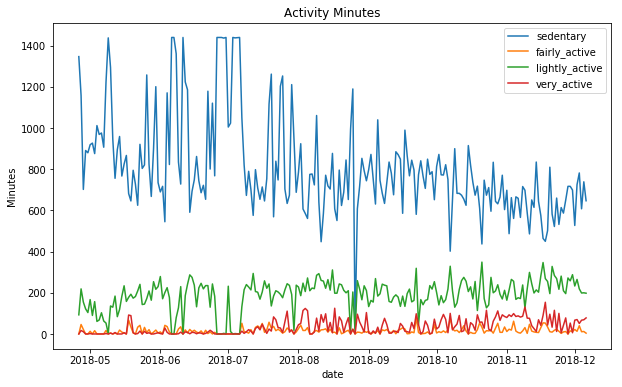

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(x=fitbit.date, y=fitbit.minutes_sedentary, label='sedentary')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_fairly_active, label='fairly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_lightly_active, label='lightly_active')
sns.lineplot(x=fitbit.date, y=fitbit.minutes_very_active, label='very_active')
plt.ylabel('Minutes')
plt.title('Activity Minutes')
plt.show()

##### Glancing at the individual's activity as a percentage of the time awake

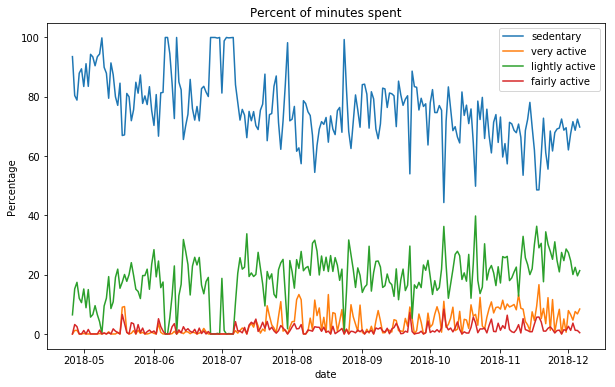

In [10]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_sedentary/fitbit.total_minutes*100), label='sedentary')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_very_active/fitbit.total_minutes*100), label='very active')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_lightly_active/fitbit.total_minutes*100), label='lightly active')
sns.lineplot(x=fitbit.date, y=(fitbit.minutes_fairly_active/fitbit.total_minutes*100), label='fairly active')
plt.title('Percent of minutes spent')
plt.ylabel('Percentage')
plt.show()

### Setting the index to be the date
This allows us to resample data which makes for nicer plots.

In [11]:
fitbit.set_index('date', inplace=True, drop=True)

##### Weekly average of steps, aggregated based on weekend or weekday

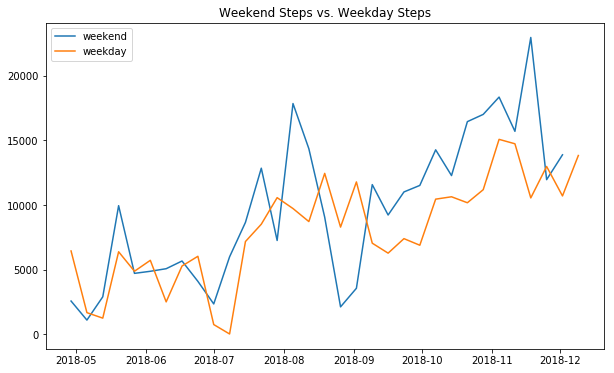

In [12]:
weekend = fitbit.loc[fitbit.weekend_or_weekday == 'weekend']
weekday = fitbit.loc[fitbit.weekend_or_weekday == 'weekday']

weekend = weekend.resample('W')['steps'].mean()
weekday = weekday.resample('W')['steps'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, label='weekend')
sns.lineplot(data=weekday, label='weekday')
plt.title('Weekend Steps vs. Weekday Steps')
plt.show()

##### Weekly average of minutes sedentary, aggregated based on weekday or weekend

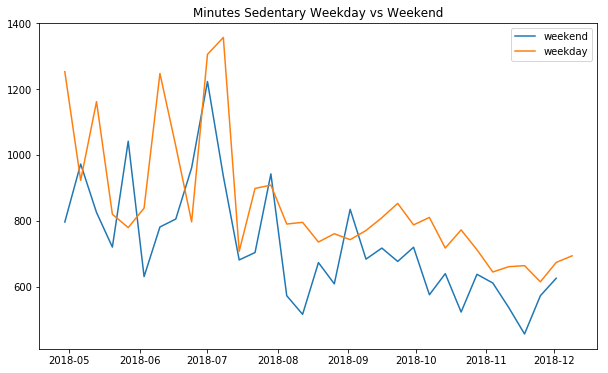

In [13]:
weekend = fitbit.loc[fitbit.weekend_or_weekday == 'weekend']
weekday = fitbit.loc[fitbit.weekend_or_weekday == 'weekday']

weekend = weekend.resample('W')['minutes_sedentary'].mean()
weekday = weekday.resample('W')['minutes_sedentary'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekend, label='weekend')
sns.lineplot(data=weekday, label='weekday')
plt.title('Minutes Sedentary Weekday vs Weekend')
plt.show()

##### Glancing at the distribution of total minutes

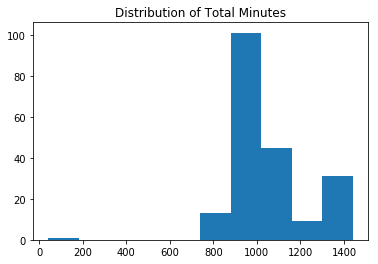

In [14]:
plt.hist(fitbit.total_minutes.iloc[:200])
plt.title('Distribution of Total Minutes')
plt.show()

##### Glancing distribution of floors

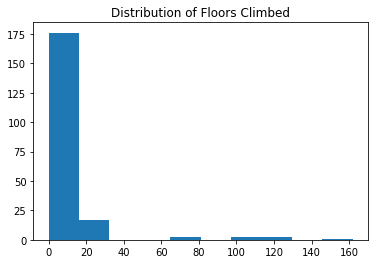

In [15]:
plt.hist(fitbit.floors.iloc[:200])
plt.title('Distribution of Floors Climbed')
plt.show()

##### Sampling based on amount of days. (Steps)
We want the test data set to be at least 30 days so that any monthly trends can be tested.

(194,)
(31,)


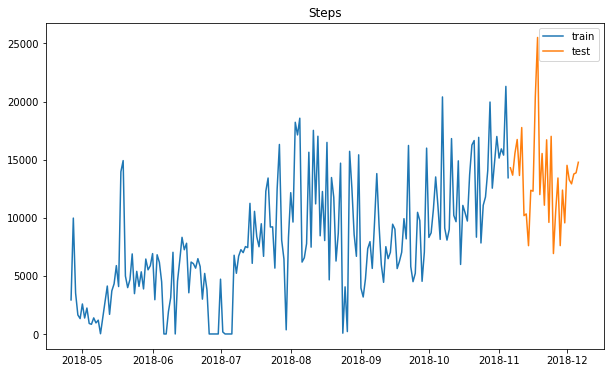

In [16]:
train = fitbit.steps[:194]
test = fitbit.steps[194:225]
data_to_predict = fitbit.steps[225:]

print(train.shape)
print(test.shape)

plt.figure(figsize=(10, 6))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.title('Steps')
plt.legend()
plt.show()

##### Creating a `yhat` DataFrame to store predicted values.

In [17]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

actual  avg_forecast
date                             
2018-11-06  14300.0   7757.231959
2018-11-07  13664.0   7757.231959
2018-11-08  15542.0   7757.231959
2018-11-09  16732.0   7757.231959
2018-11-10  13636.0   7757.231959

##### Some very useful functions for plotting actual and predicted values, as well as calculating the MSE and RMSE

In [18]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

### Simple Average

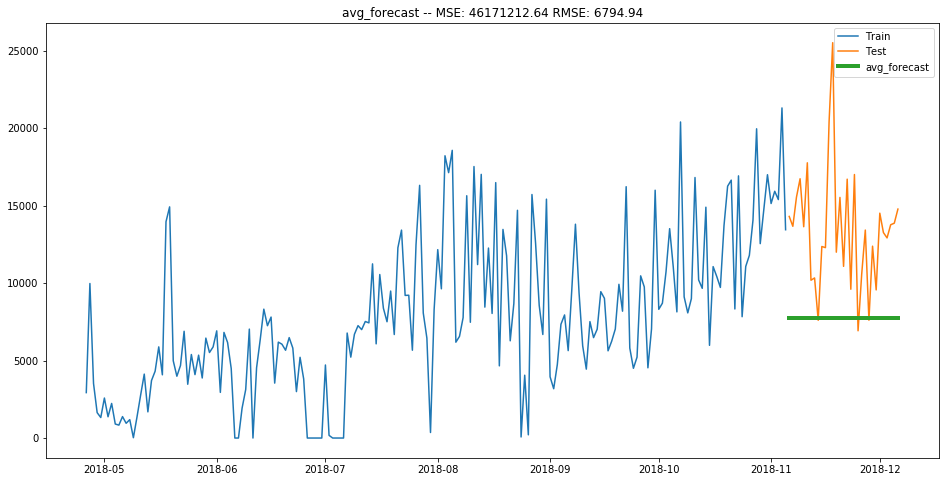

In [19]:
plot_and_eval(yhat.avg_forecast)

### Rolling Average
##### Past 1 day, 1 week, 2 weeks, 3 weeks,1 month,  2 months, and 3 months

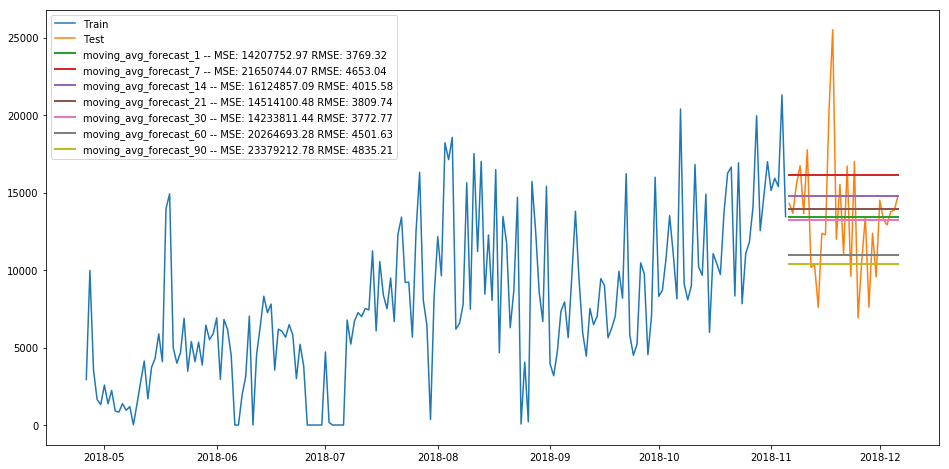

In [20]:
period_vals = [1, 7, 14, 21, 30, 60, 90]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

### Holt Linear Trend

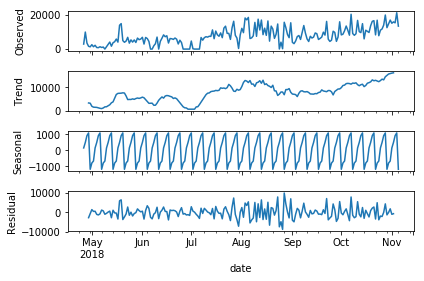

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


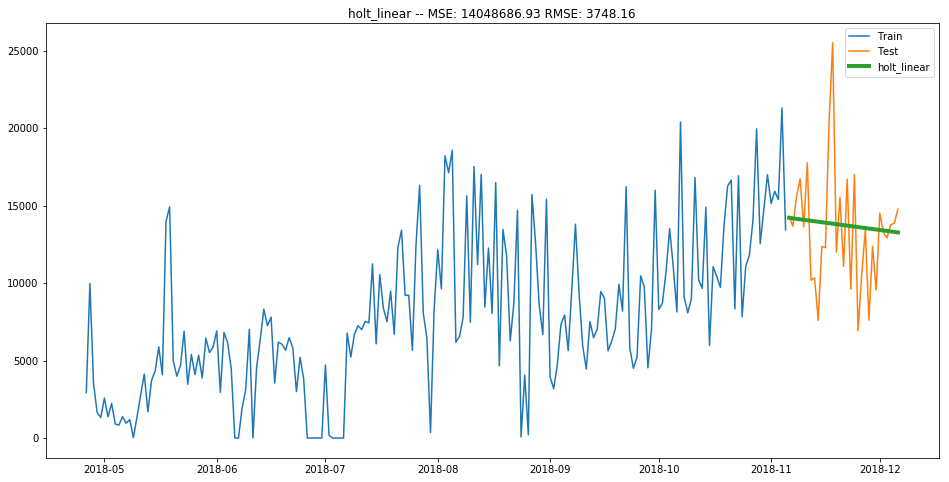

In [21]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

### Predicting based off last N days
31 days in this case. This model performs poorly and when looking at the data, it is obvious that the next 30 days will not look similar to the previous 30 days.

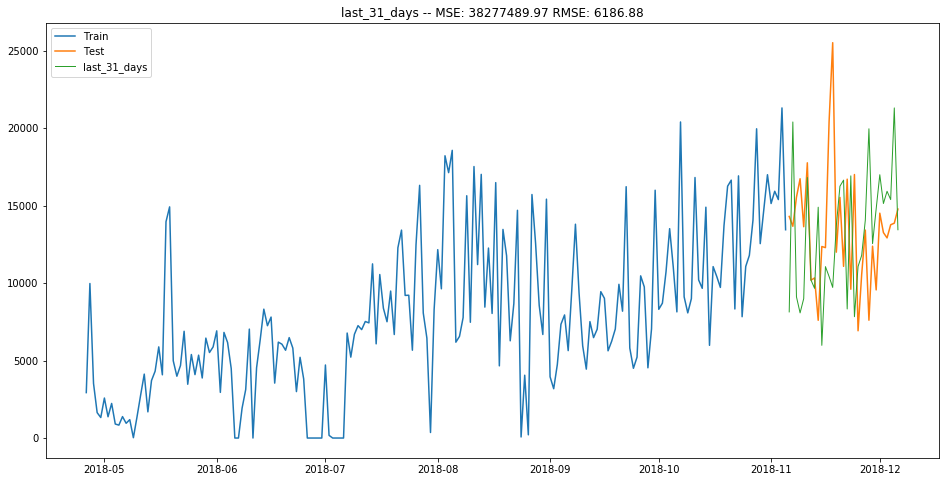

In [22]:
using_last_year = train[163:194].reset_index().drop(columns='date').set_index(test.index)

yhat['last_31_days'] = using_last_year
plot_and_eval(yhat.last_31_days, linewidth=1)

### Prophet Model

### Making a variable that contains the relevant columns we are trying to predict on.
This will help when running through for loops.

In [47]:
def fb_prophet_all(df, periods):
    feats_predict = ['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']   
    for feat in feats_predict:
    
        variable = df[feat]
        train = variable[:194]
        test = variable[194:225]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

        test_df = test.to_frame()
        forecast_df.set_index('ds', inplace=True)
        forecast_df = forecast_df.join(test_df)
        forecast_df.yhat = forecast_df.yhat.astype(int)
        forecast_df['error'] = forecast_df[feat] - forecast_df['yhat']
        forecast_df['abs_error'] = abs(forecast_df['error'])
        forecast_df['sqr_error'] = forecast_df['abs_error'] ** 2
        rmse = (forecast_df.sqr_error.sum()/forecast_df.shape[0]) ** .5 
        print(str(feat) + ':')
        print('rmse: ' + str(rmse))
        print(str(feat) + ':')
        print(forecast_df.head(3))
        print(str(feat) + ':')
        print(forecast_df.tail(3))
        print(str(feat) + ':')
        print(m.plot(forecast))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


calories_burned:
rmse: 422.753073661591
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-11-06  3675  2937.742641  4512.813621           3801.0  126.0      126.0   
2018-11-07  3665  2937.654734  4410.724065           3681.0   16.0       16.0   
2018-11-08  3774  2975.227363  4581.243213           4137.0  363.0      363.0   

            sqr_error  
ds                     
2018-11-06    15876.0  
2018-11-07      256.0  
2018-11-08   131769.0  
calories_burned:
            yhat   yhat_lower   yhat_upper  calories_burned  error  abs_error  \
ds                                                                              
2018-12-04  3786  3027.552255  4513.221724           3384.0 -402.0      402.0   
2018-12-05  3775  3028.744303  4514.778257           3670.0 -105.0      105.0   
2018-12-06  3884  3113.359404  4649.335985           3669.0 -215.0      215.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


steps:
rmse: 3937.8585755827144
steps:
             yhat   yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                         
2018-11-06  12889  7535.251496  17818.418238  14300.0  1411.0     1411.0   
2018-11-07  13099  7995.781017  17609.064844  13664.0   565.0      565.0   
2018-11-08  14062  8814.766270  19120.808367  15542.0  1480.0     1480.0   

            sqr_error  
ds                     
2018-11-06  1990921.0  
2018-11-07   319225.0  
2018-11-08  2190400.0  
steps:
             yhat    yhat_lower    yhat_upper    steps   error  abs_error  \
ds                                                                          
2018-12-04  14815   9466.906612  19921.546926  13763.0 -1052.0     1052.0   
2018-12-05  15022   9990.700263  20335.789040  13865.0 -1157.0     1157.0   
2018-12-06  15982  11036.685886  21106.044715  14774.0 -1208.0     1208.0   

            sqr_error  
ds                     
2018-12-04  1106704

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


distance:
rmse: 1.7467536709841986
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-11-06     6    3.645049    8.384206      6.74   0.74       0.74   
2018-11-07     6    3.894276    8.601297      6.46   0.46       0.46   
2018-11-08     6    4.302031    8.936896      7.33   1.33       1.33   

            sqr_error  
ds                     
2018-11-06     0.5476  
2018-11-07     0.2116  
2018-11-08     1.7689  
distance:
            yhat  yhat_lower  yhat_upper  distance  error  abs_error  \
ds                                                                     
2018-12-04     7    4.722735    9.353542      6.49  -0.51       0.51   
2018-12-05     7    4.785751    9.665060      6.52  -0.48       0.48   
2018-12-06     7    4.971498   10.031352      6.96  -0.04       0.04   

            sqr_error  
ds                     
2018-12-04     0.2601  
2018-12-05     0.2304  
2018-12

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


floors:
rmse: 47.69053466647437
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-11-06    17   -5.785592   41.214866    16.0   -1.0        1.0        1.0
2018-11-07    18   -6.292619   41.119264     9.0   -9.0        9.0       81.0
2018-11-08    13  -11.337406   36.404532    26.0   13.0       13.0      169.0
floors:
            yhat  yhat_lower  yhat_upper  floors  error  abs_error  sqr_error
ds                                                                           
2018-12-04    20   -2.310126   43.251778    13.0   -7.0        7.0       49.0
2018-12-05    20   -1.851795   44.111377    12.0   -8.0        8.0       64.0
2018-12-06    16   -7.341001   39.658439     9.0   -7.0        7.0       49.0
floors:
Figure(720x432)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_sedentary:
rmse: 94.09398184450926
minutes_sedentary:
            yhat  yhat_lower   yhat_upper  minutes_sedentary  error  \
ds                                                                    
2018-11-06   664  389.161885   932.378865              659.0   -5.0   
2018-11-07   719  461.035180  1020.972120              566.0 -153.0   
2018-11-08   683  402.772572   948.196559              716.0   33.0   

            abs_error  sqr_error  
ds                                
2018-11-06        5.0       25.0  
2018-11-07      153.0    23409.0  
2018-11-08       33.0     1089.0  
minutes_sedentary:
            yhat  yhat_lower  yhat_upper  minutes_sedentary  error  abs_error  \
ds                                                                              
2018-12-04   607  333.252992  873.846119              608.0    1.0        1.0   
2018-12-05   663  374.180478  952.690446              739.0   76.0       76.0   
2018-12-06   626  360.691271  898.402458              647.0   21

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_lightly_active:
rmse: 54.07581297019118
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-11-06   205  116.080553  297.042728                   176.0  -29.0   
2018-11-07   191  102.648014  283.517741                   172.0  -19.0   
2018-11-08   211  125.266267  299.984547                   238.0   27.0   

            abs_error  sqr_error  
ds                                
2018-11-06       29.0      841.0  
2018-11-07       19.0      361.0  
2018-11-08       27.0      729.0  
minutes_lightly_active:
            yhat  yhat_lower  yhat_upper  minutes_lightly_active  error  \
ds                                                                        
2018-12-04   213  121.761548  307.410940                   199.0  -14.0   
2018-12-05   199  106.709636  289.997558                   200.0    1.0   
2018-12-06   219  134.799420  311.854269             

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_fairly_active:
rmse: 20.7815054253039
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-11-06    24    4.302022   44.844942                    7.0  -17.0   
2018-11-07    26    6.946176   45.629294                    4.0  -22.0   
2018-11-08    26    7.890837   45.952427                   15.0  -11.0   

            abs_error  sqr_error  
ds                                
2018-11-06       17.0      289.0  
2018-11-07       22.0      484.0  
2018-11-08       11.0      121.0  
minutes_fairly_active:
            yhat  yhat_lower  yhat_upper  minutes_fairly_active  error  \
ds                                                                       
2018-12-04    32   12.808449   54.354805                   11.0  -21.0   
2018-12-05    35   14.855117   56.024774                   12.0  -23.0   
2018-12-06    35   14.847682   55.064372                    4.0  -

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


minutes_very_active:
rmse: 51.24482664683837
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-11-06    76   37.804479  114.313092                 88.0   12.0   
2018-11-07    79   39.905050  115.849843                 82.0    3.0   
2018-11-08    83   45.768354  125.783682                 86.0    3.0   

            abs_error  sqr_error  
ds                                
2018-11-06       12.0      144.0  
2018-11-07        3.0        9.0  
2018-11-08        3.0        9.0  
minutes_very_active:
            yhat  yhat_lower  yhat_upper  minutes_very_active  error  \
ds                                                                     
2018-12-04   100   61.727549  139.480264                 67.0  -33.0   
2018-12-05   104   67.335637  144.163478                 69.0  -35.0   
2018-12-06   108   67.082607  147.294536                 78.0  -30.0   

            abs_

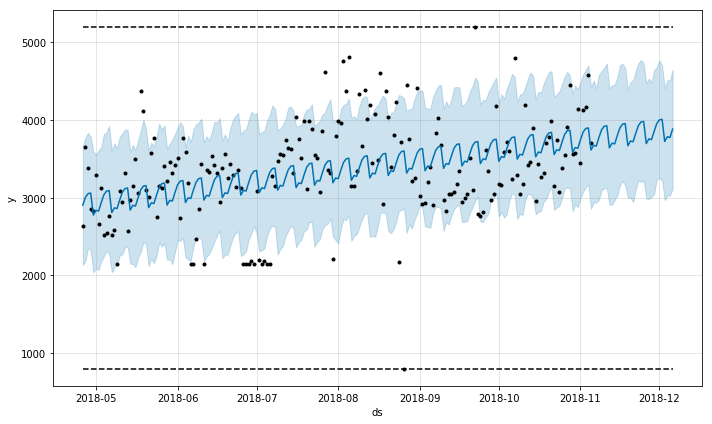

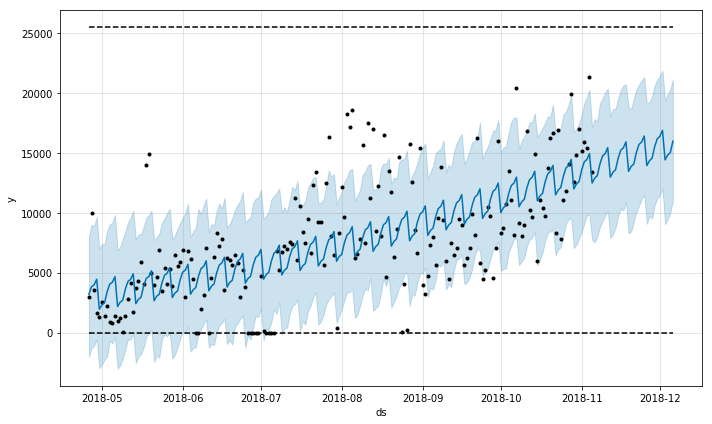

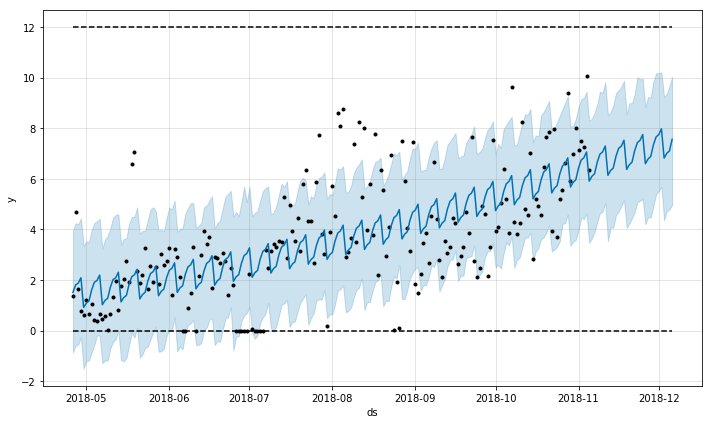

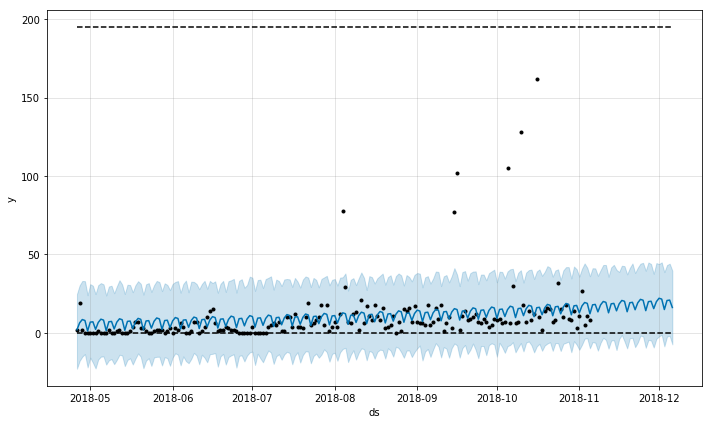

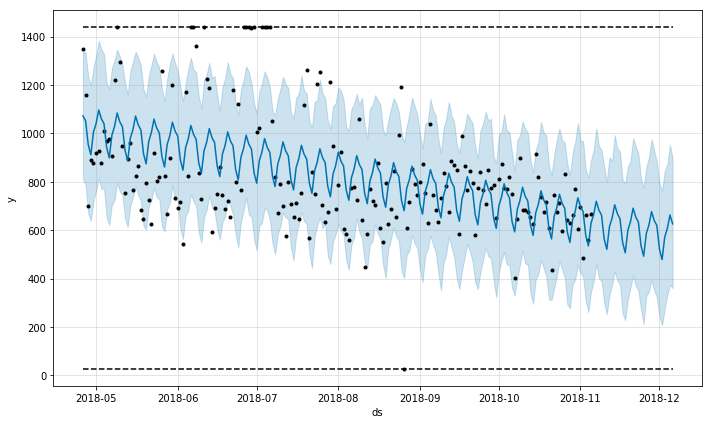

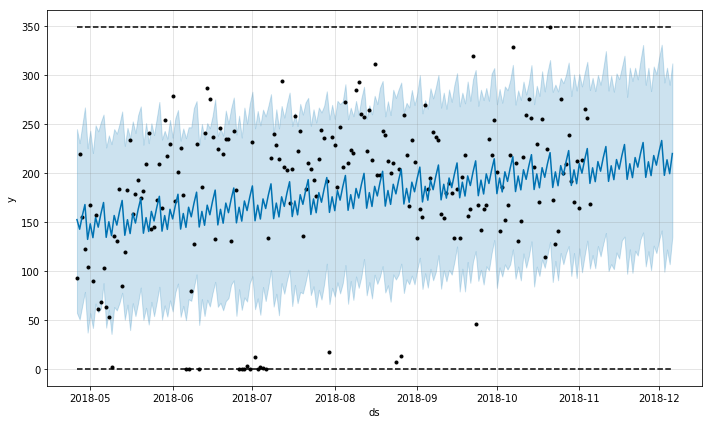

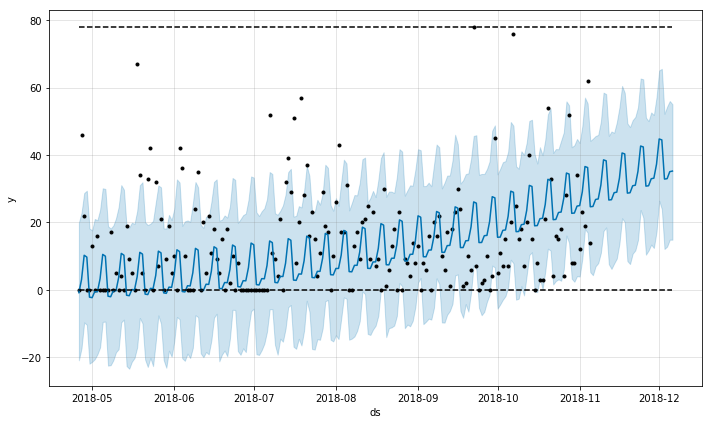

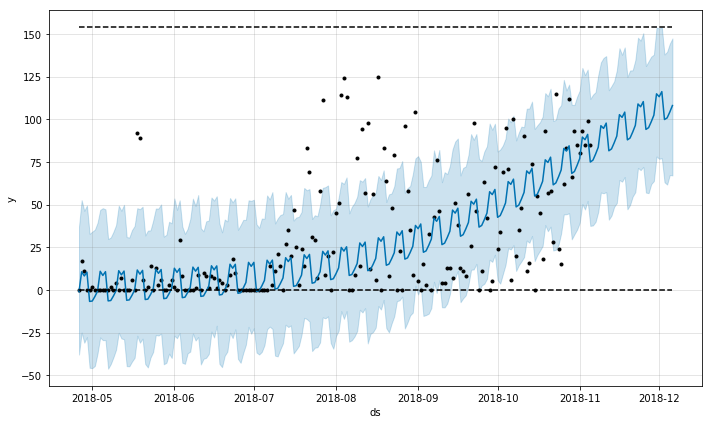

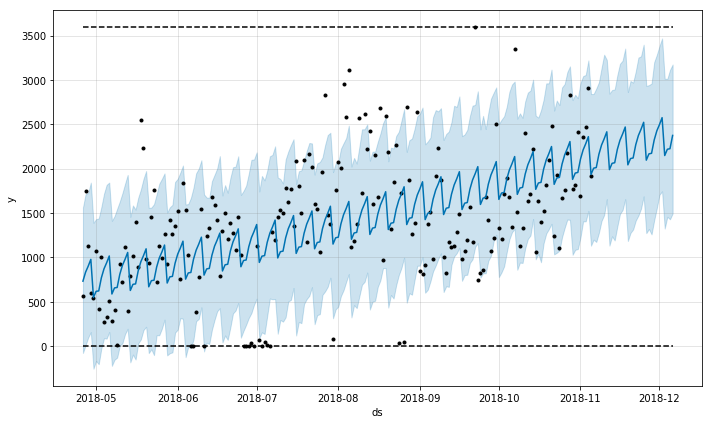

In [48]:
fb_prophet_all(fitbit,31)

In [23]:
columns = fitbit.columns[:9]

### Performing TSA for variables in `columns`.
The following block of code loops through all the relevant columns and performs the following analyses:
- simple average
- rolling average
- last 30 days

Performing TSA for calories_burned.


Train/Test plot


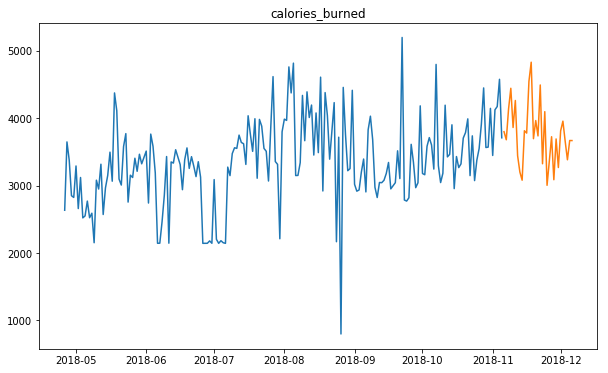



Simple Average


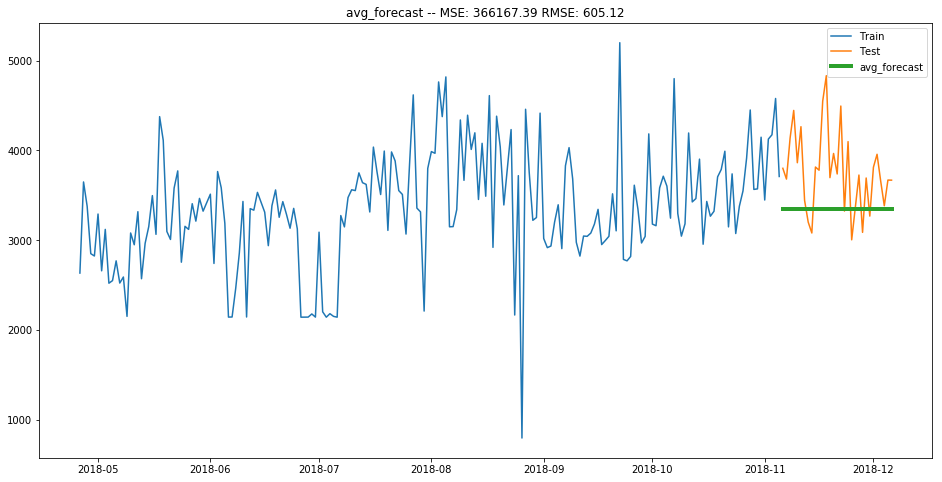



Rolling Average


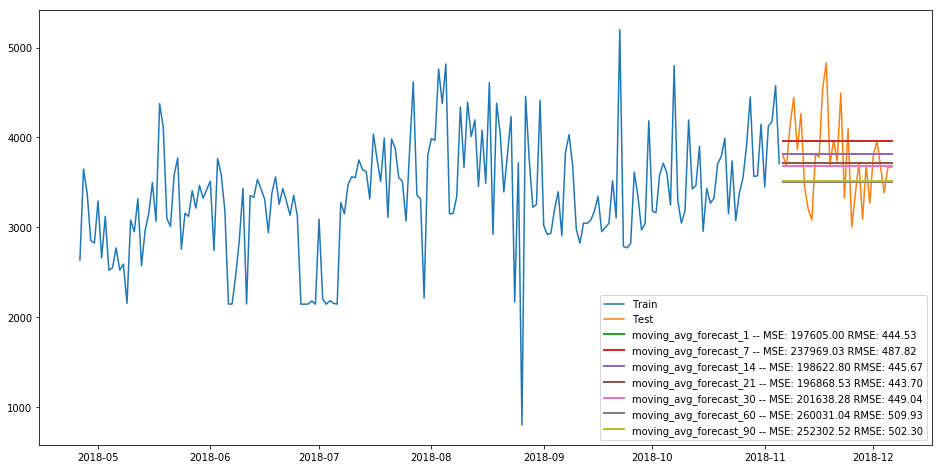



Predicting based off last 31 days


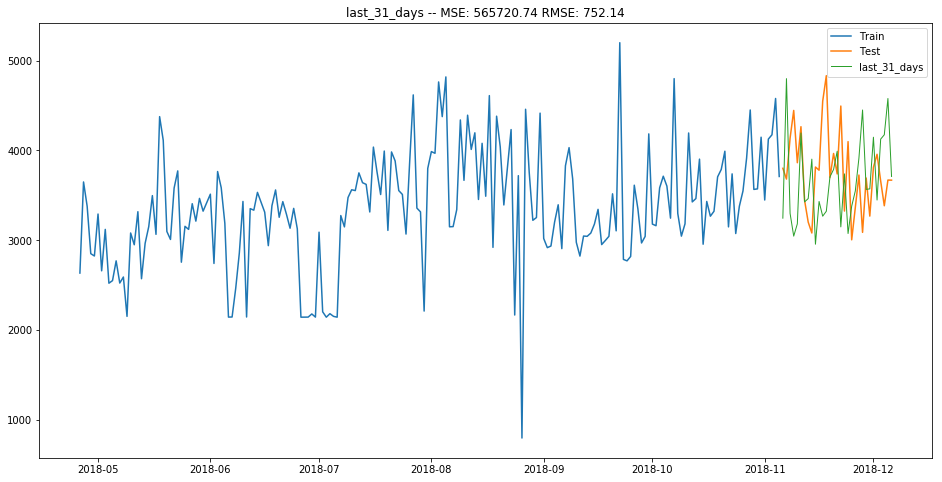

Performing TSA for steps.


Train/Test plot


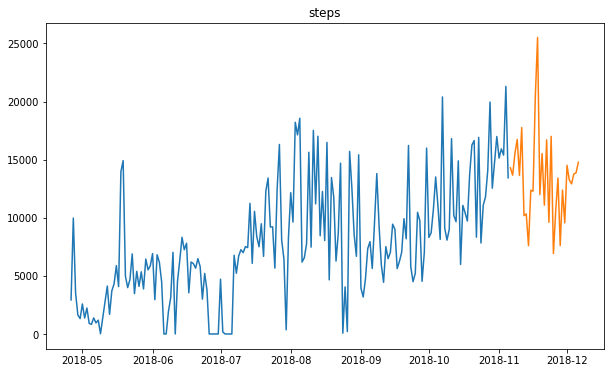



Simple Average


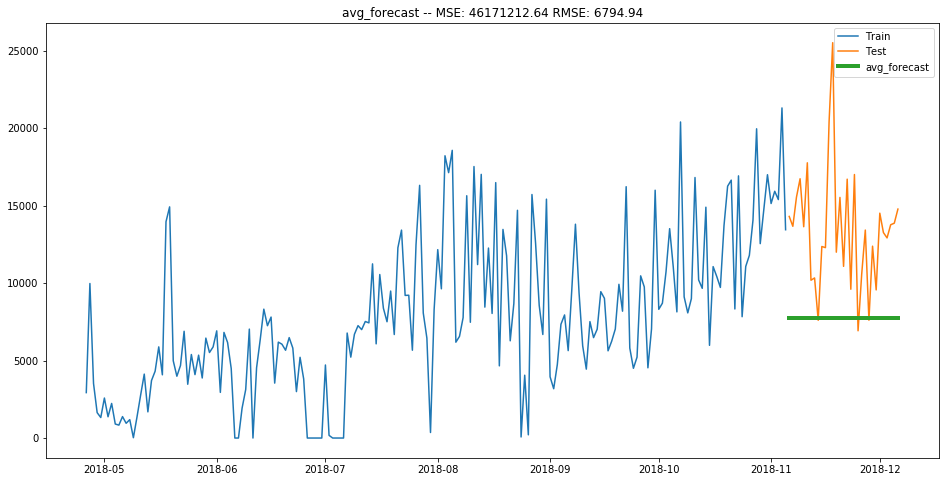



Rolling Average


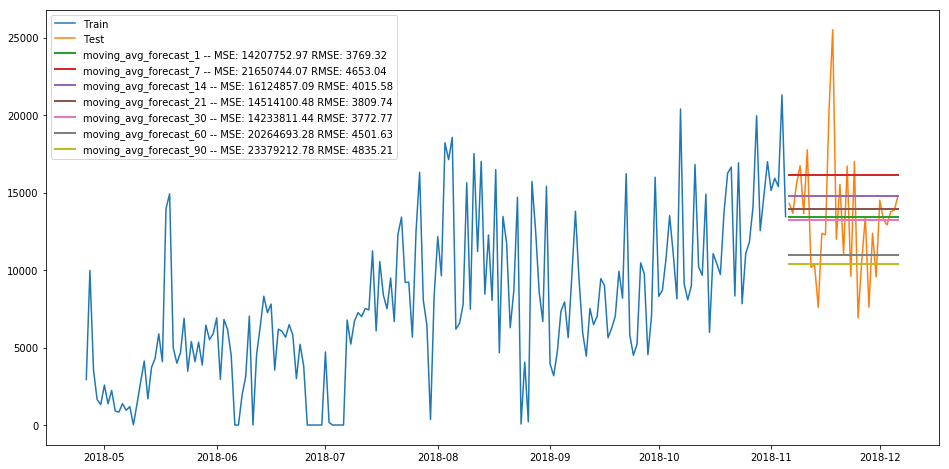



Predicting based off last 31 days


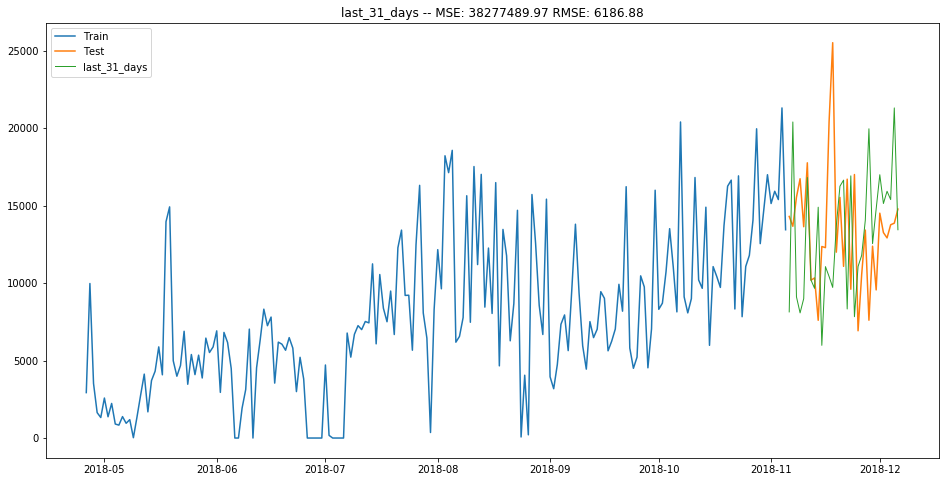

Performing TSA for distance.


Train/Test plot


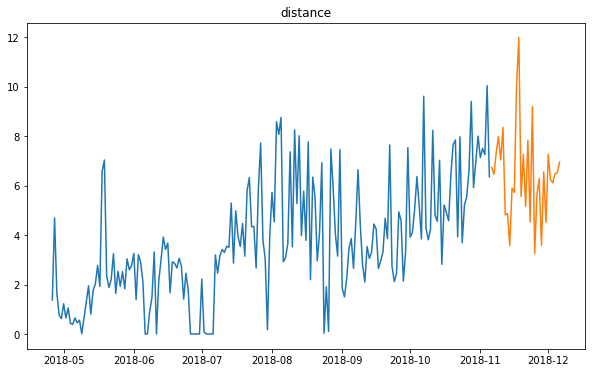



Simple Average


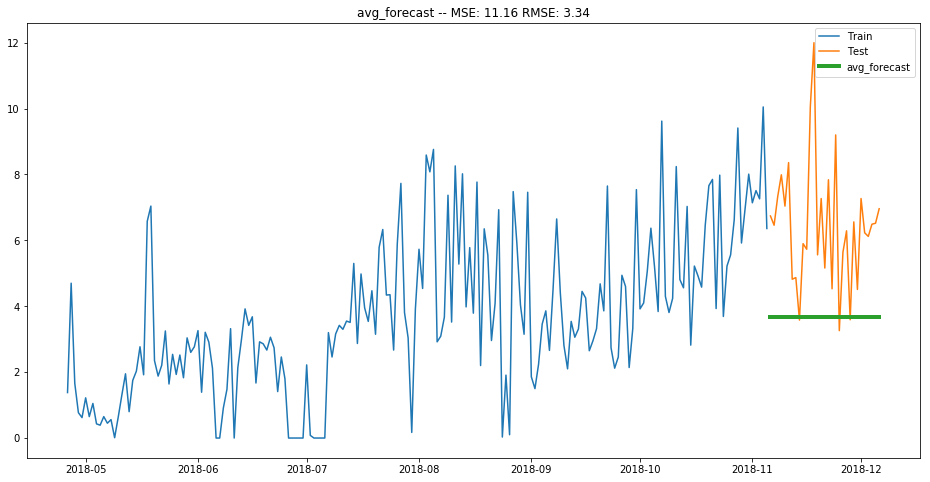



Rolling Average


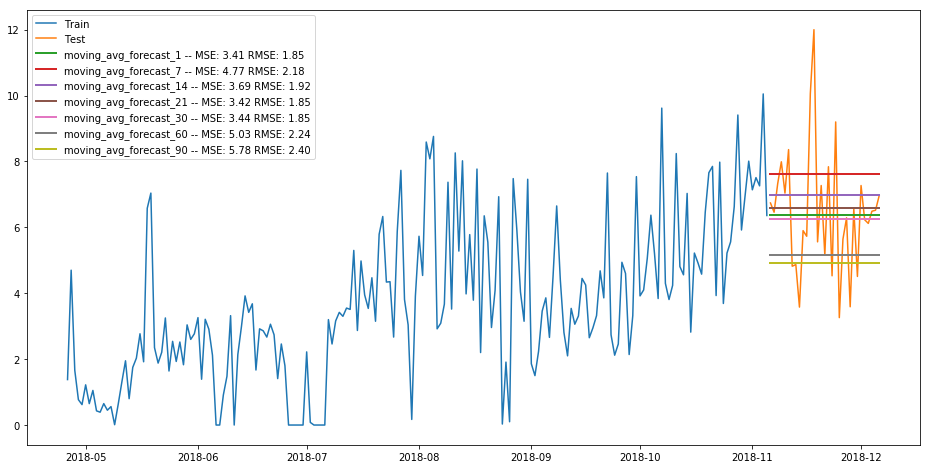



Predicting based off last 31 days


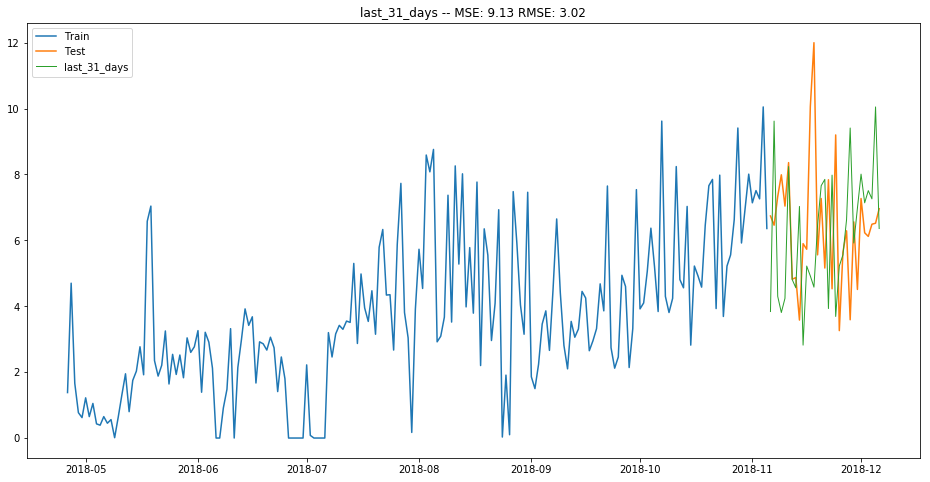

Performing TSA for floors.


Train/Test plot


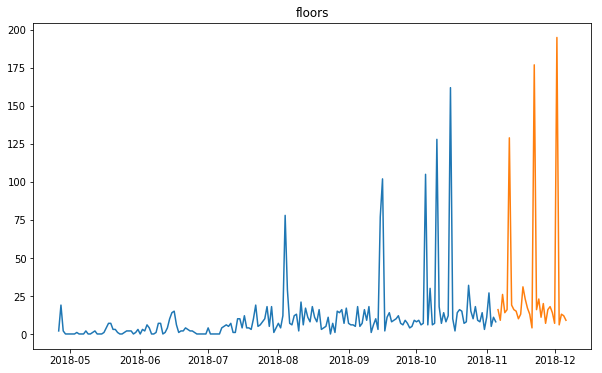



Simple Average


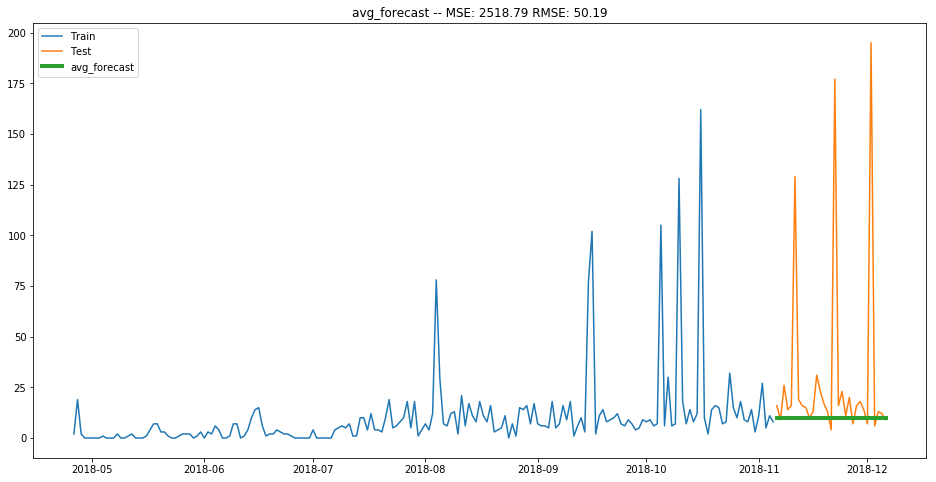



Rolling Average


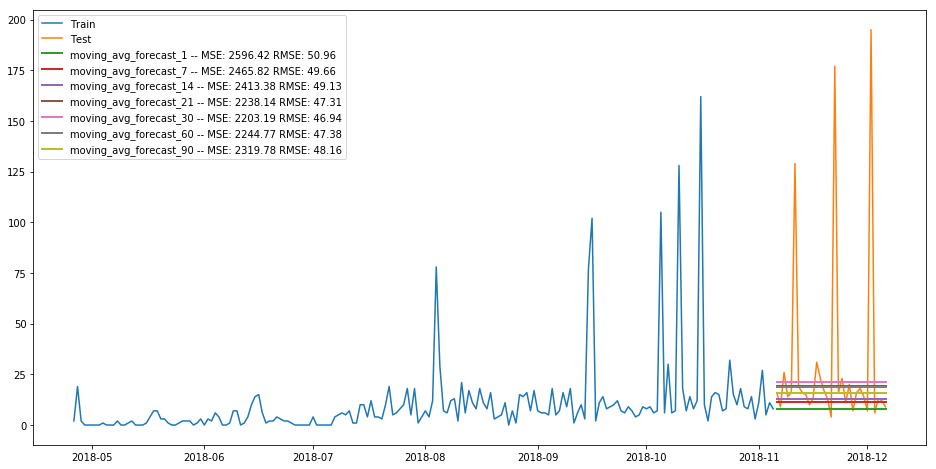



Predicting based off last 31 days


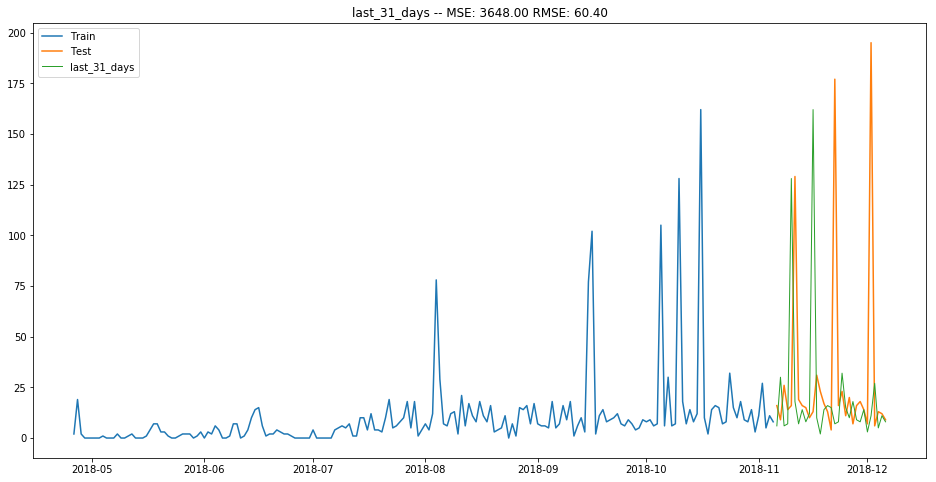

Performing TSA for minutes_sedentary.


Train/Test plot


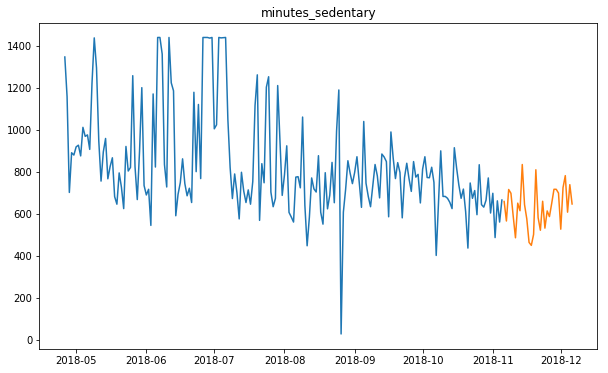



Simple Average


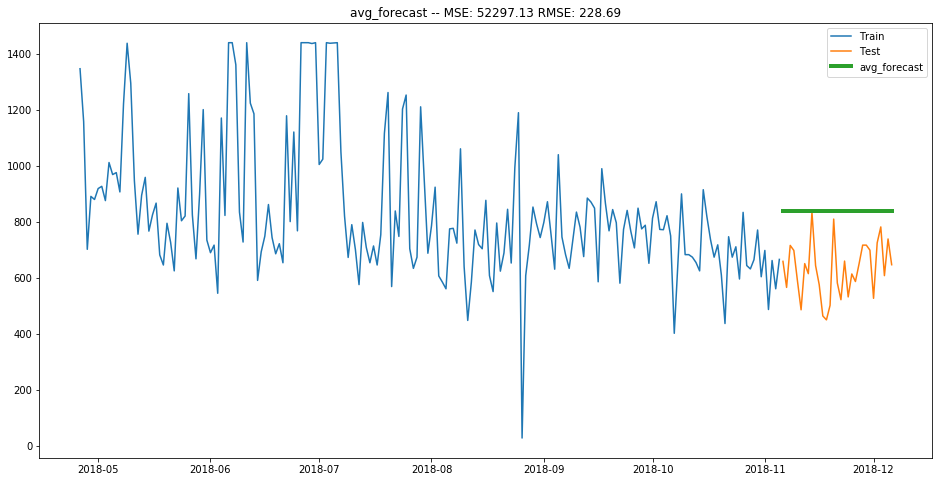



Rolling Average


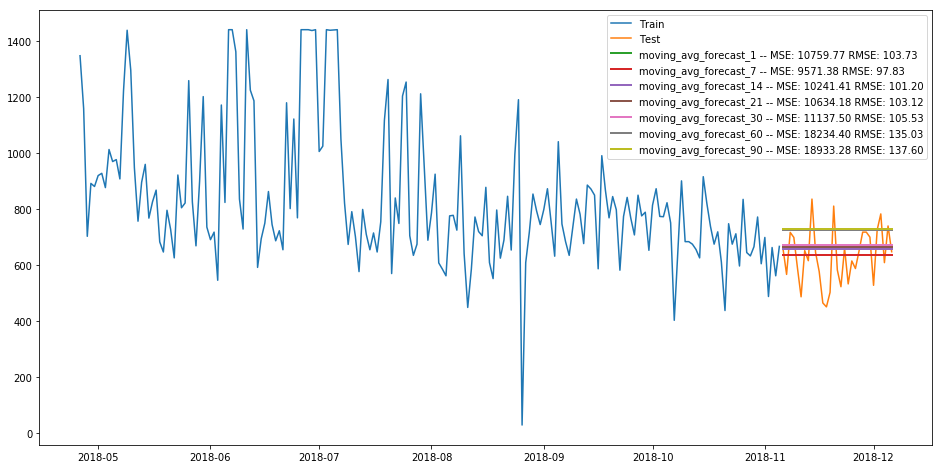



Predicting based off last 31 days


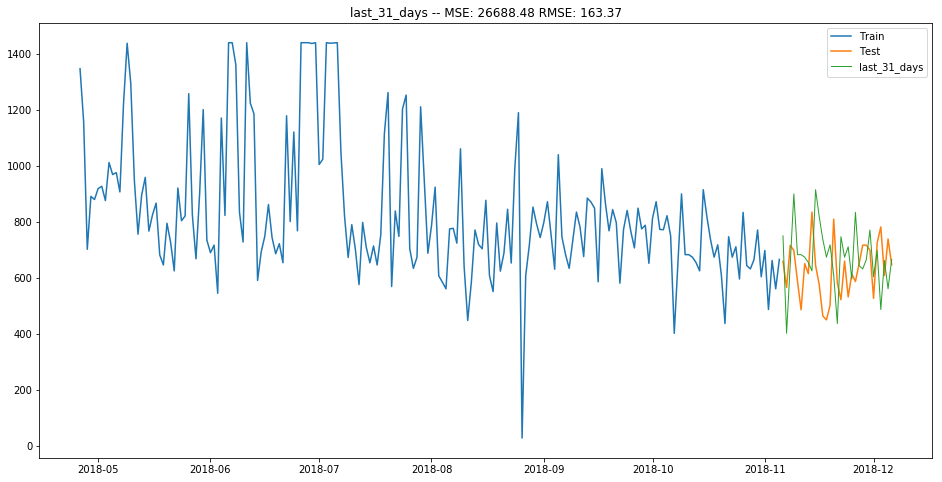

Performing TSA for minutes_lightly_active.


Train/Test plot


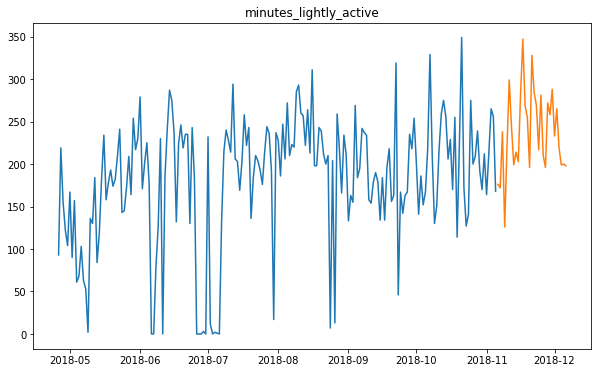



Simple Average


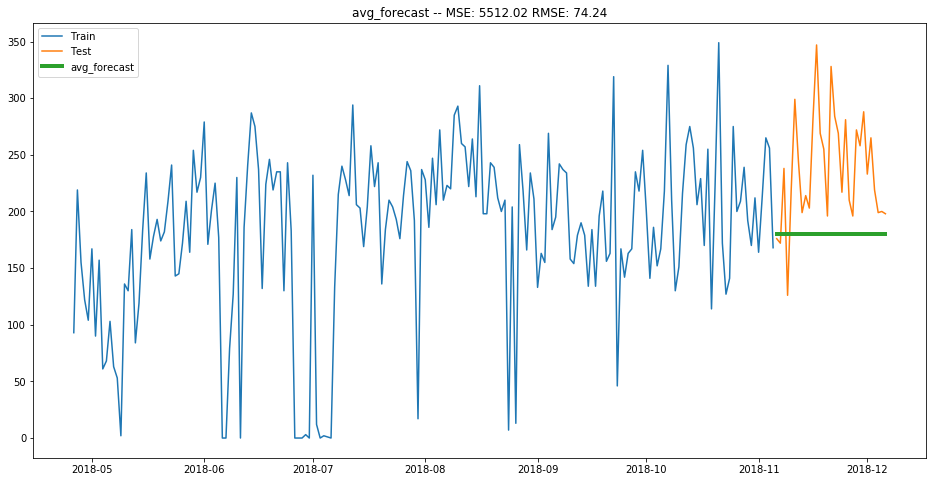



Rolling Average


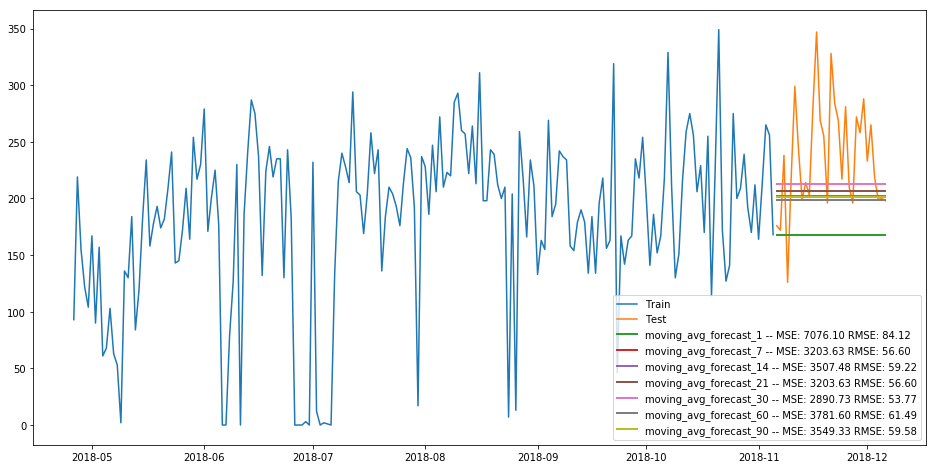



Predicting based off last 31 days


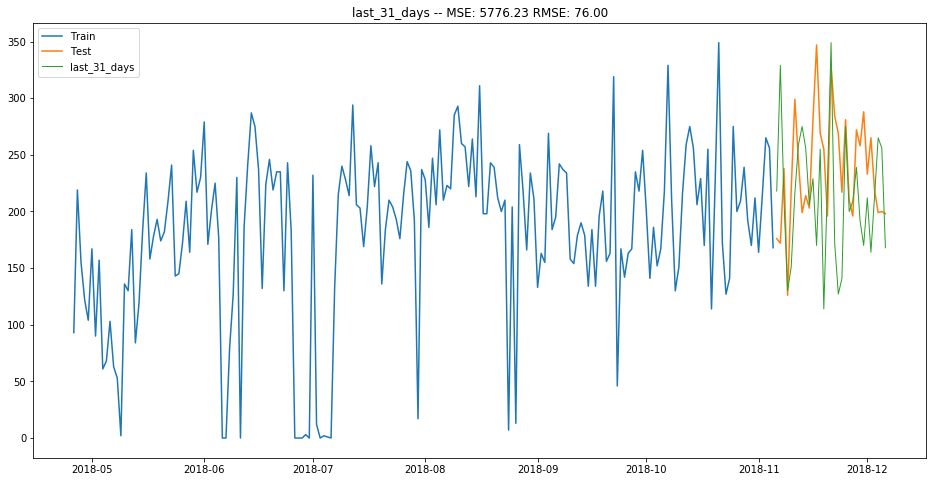

Performing TSA for minutes_fairly_active.


Train/Test plot


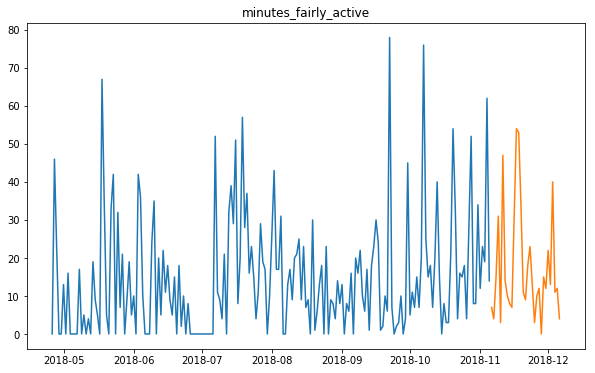



Simple Average


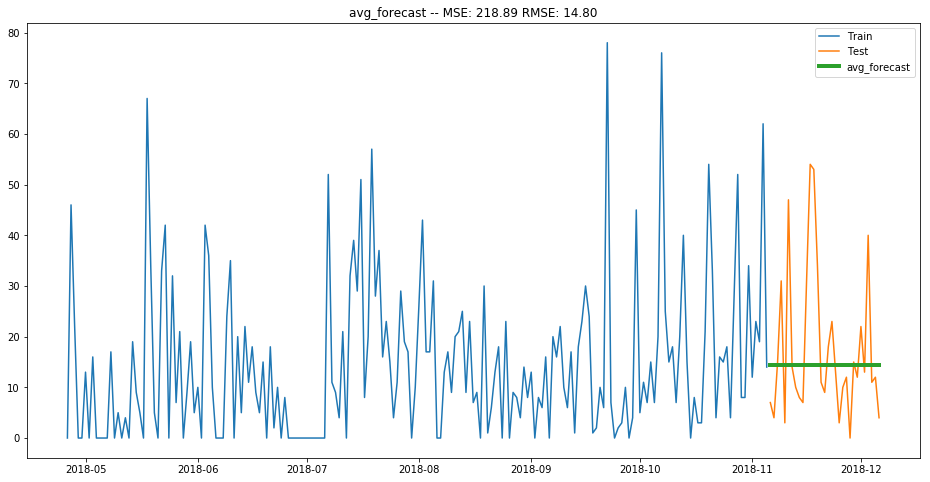



Rolling Average


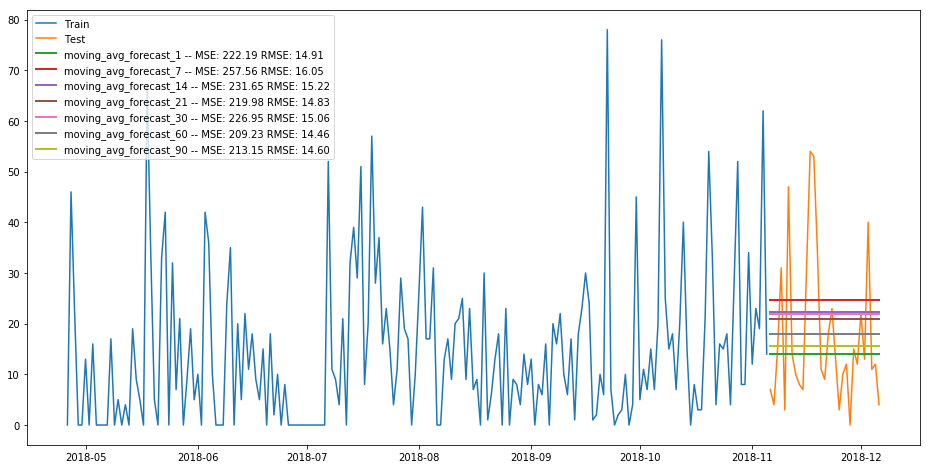



Predicting based off last 31 days


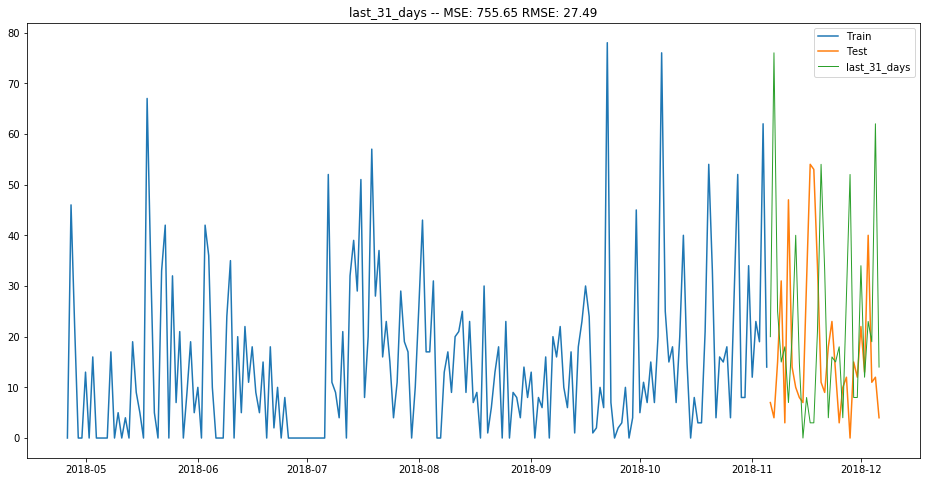

Performing TSA for minutes_very_active.


Train/Test plot


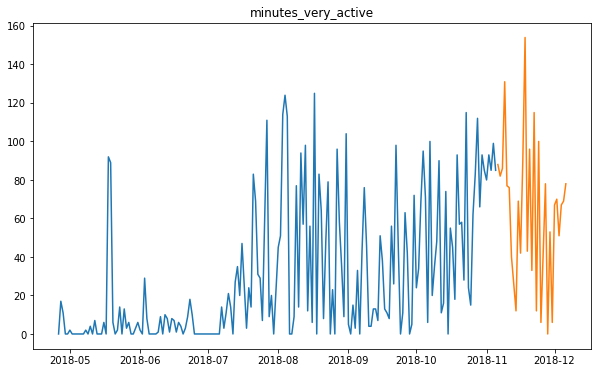



Simple Average


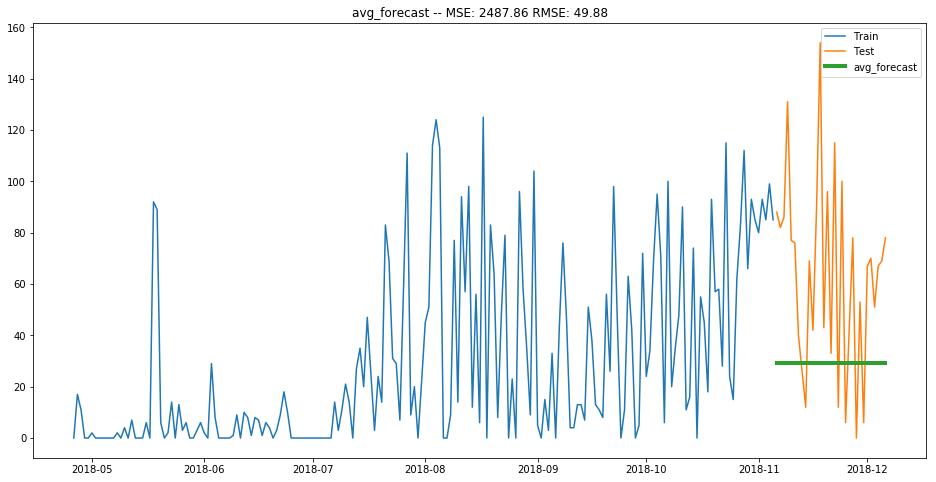



Rolling Average


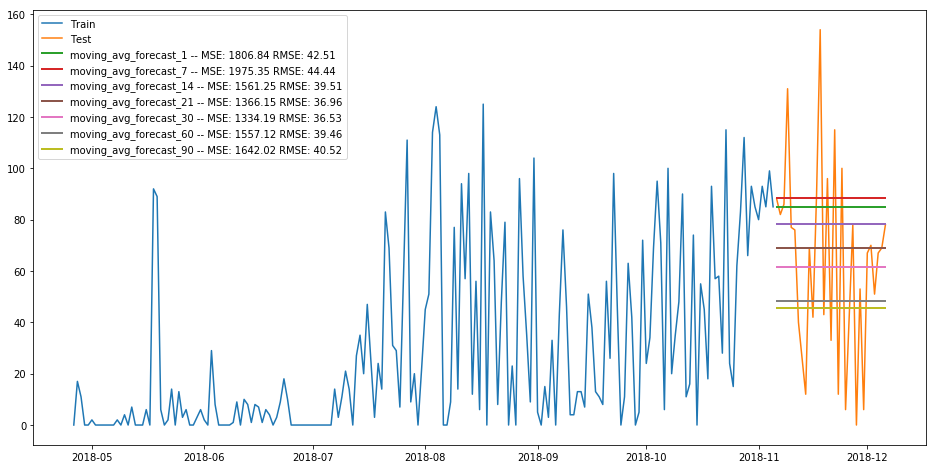



Predicting based off last 31 days


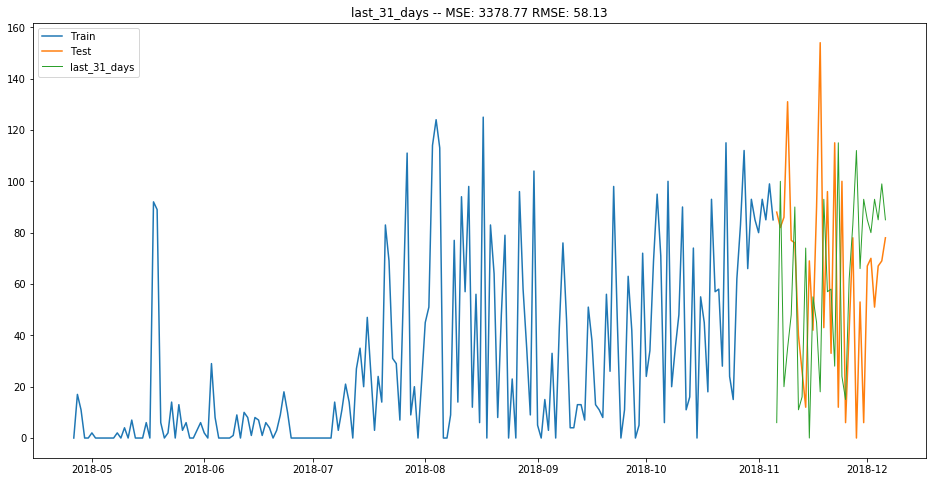

Performing TSA for activity_calories.


Train/Test plot


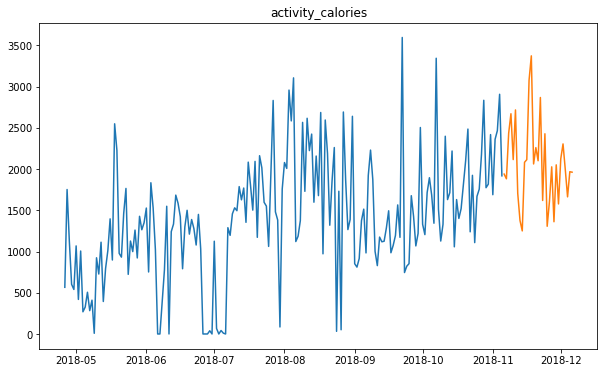



Simple Average


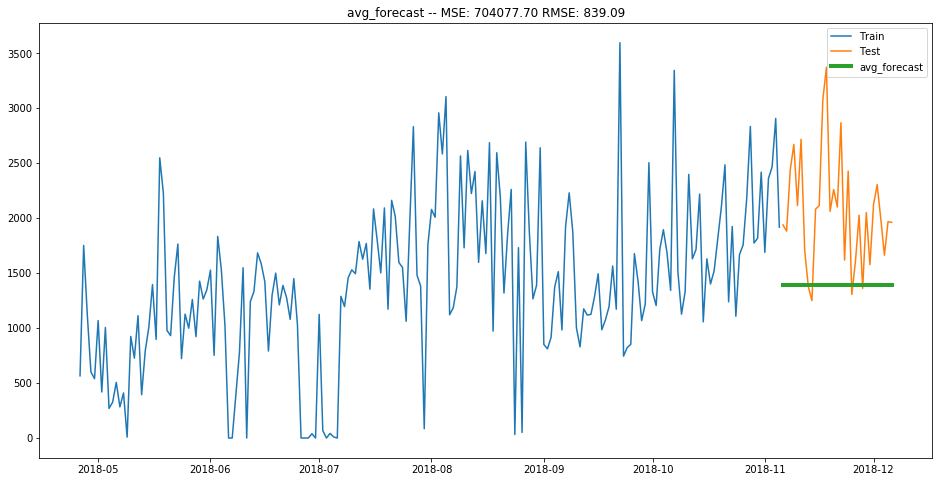



Rolling Average


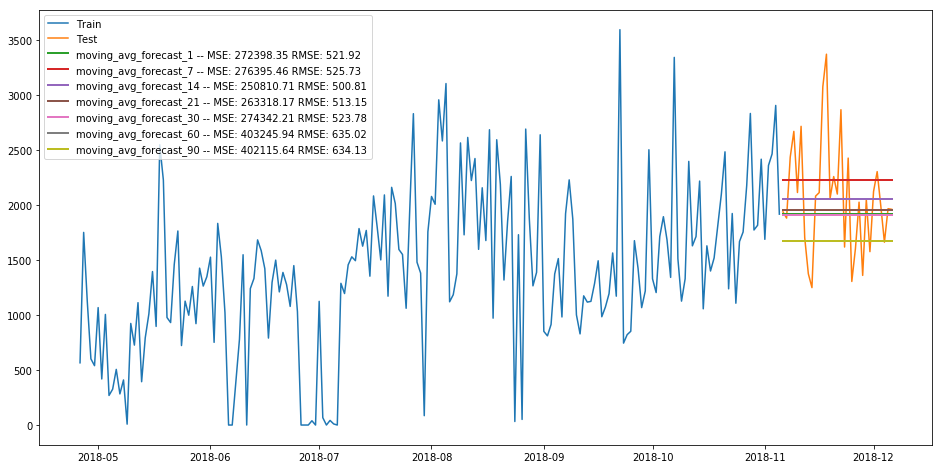



Predicting based off last 31 days


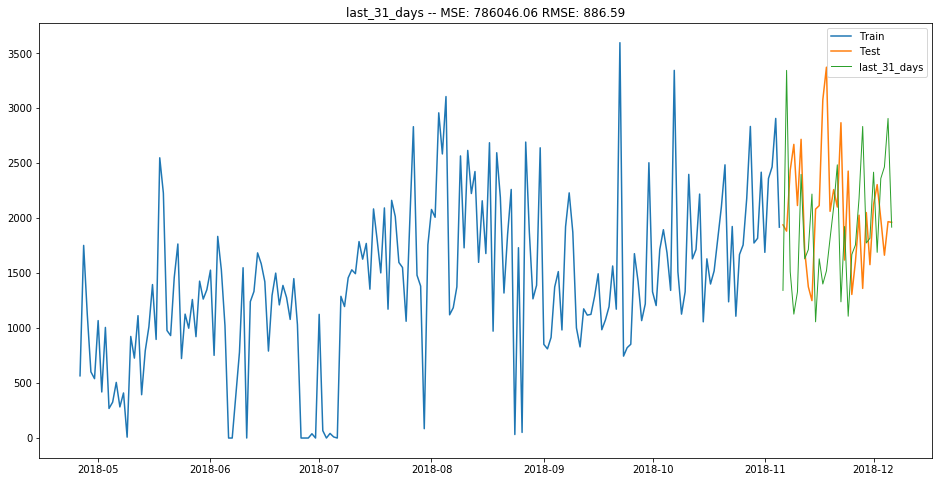

In [24]:
for col in columns:
    print(f'Performing TSA for {col}.')
    train = fitbit[col][:194]
    test = fitbit[col][194:225]
    data_to_predict = fitbit[col][225:]

    print('\n')
    print(f'Train/Test plot')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train)
    plt.plot(test)
    plt.title(col)
    plt.show()
    
    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()
    
    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    
    
    print('\n')
    print(f'Simple Average')
    plot_and_eval(yhat.avg_forecast)
    
    print('\n')
    print(f'Rolling Average')
    
    period_vals = [1, 7, 14, 21, 30, 60, 90]

    for periods in period_vals:
        yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

    forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

    plot_and_eval(forecasts, linewidth=2)
    
#     print('\n')
#     print(f'Holt Linear Trend')
    
#     sm.tsa.seasonal_decompose(train).plot()
#     result = sm.tsa.stattools.adfuller(train)
#     plt.show()
    
#     holt = Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

#     yhat['holt_linear'] = holt.forecast(test.shape[0])
    
#     plot_and_eval(yhat.holt_linear)
    
    print('\n')
    print(f'Predicting based off last 31 days')
    
    using_last_year = train[163:194].reset_index().drop(columns='date').set_index(test.index)

    yhat['last_31_days'] = using_last_year
    plot_and_eval(yhat.last_31_days, linewidth=1)

### Performing Holt Linear Modeling on `columns`.
Even after tweaking the parameters, rolling average is still better performing in some cases.

##### This dictionary will store the MSE and RMSE values

In [25]:
holt_error = {'holt mse':[], 'holt rmse':[]}

##### This function is used to make creating holt models easier.

In [26]:
def holt_linear(col, smoothing_level, smoothing_slope):
    print(col)
    train = fitbit[col][:194]
    test = fitbit[col][194:225]

    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()

    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    
        return mse, rmse

    print(f'Holt Linear Trend')

    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()

    holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    yhat['holt_linear'] = holt.forecast(test.shape[0])

    mse, rmse = plot_and_eval(yhat.holt_linear)
    holt_error['holt mse'].append(mse)
    holt_error['holt rmse'].append(rmse)
    return holt


calories_burned
Holt Linear Trend


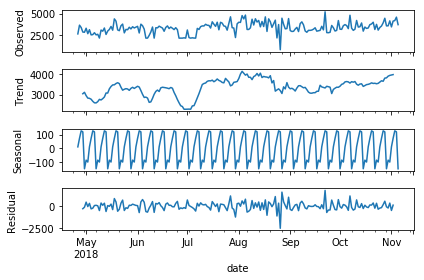

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


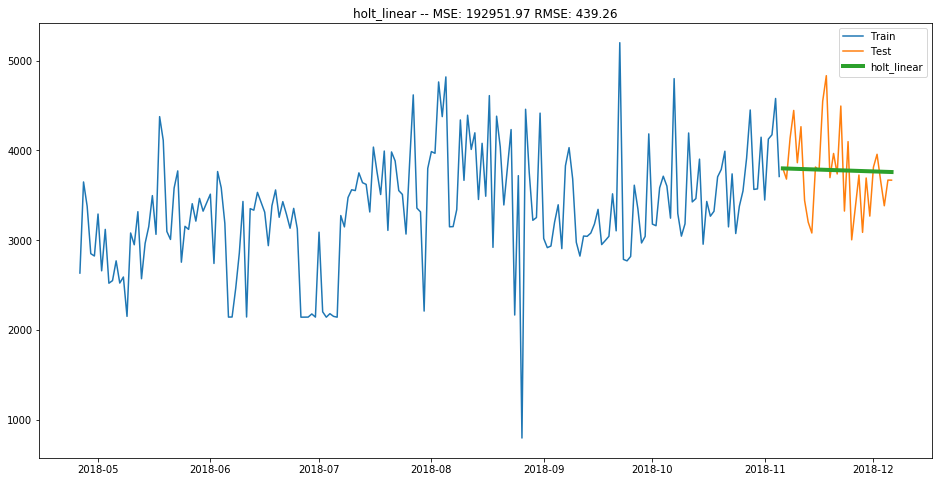

In [27]:
holt_linear('calories_burned', .9, .1)

steps
Holt Linear Trend


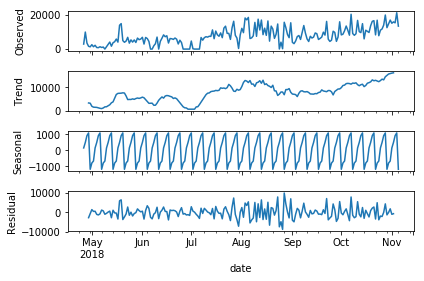

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


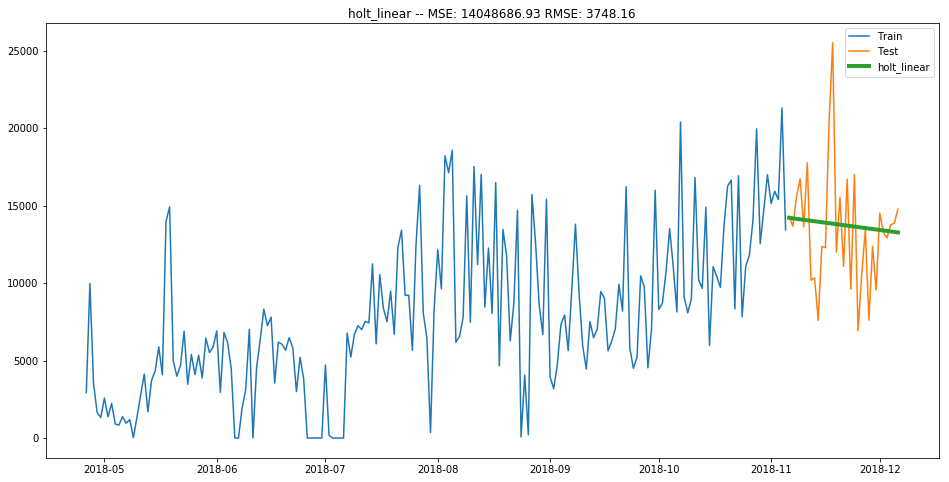

In [28]:
holt_linear('steps', .9, .1)

distance
Holt Linear Trend


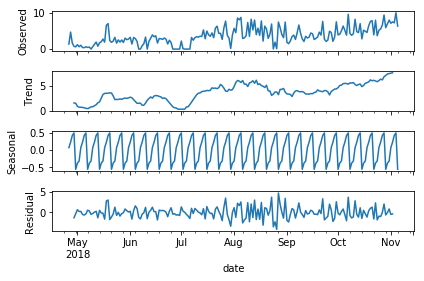

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


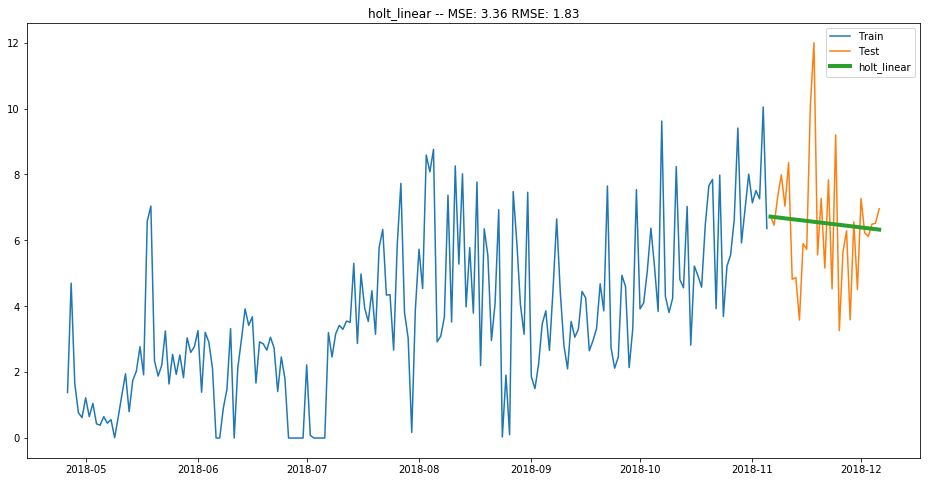

In [29]:
holt_linear('distance', .9, .1)

floors
Holt Linear Trend


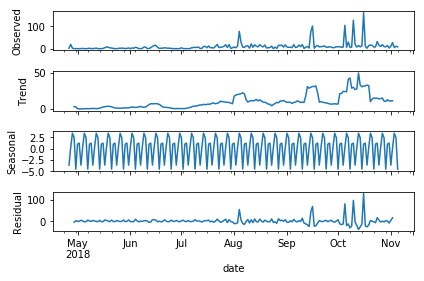

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


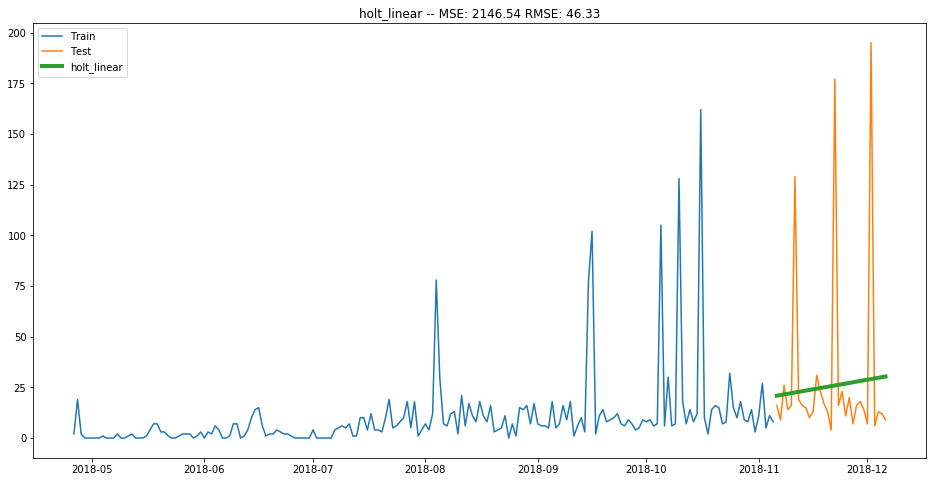

In [30]:
holt_linear('floors', .095, .905)

minutes_sedentary
Holt Linear Trend


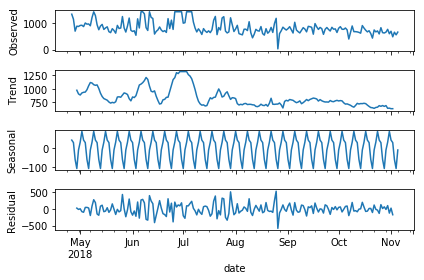

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


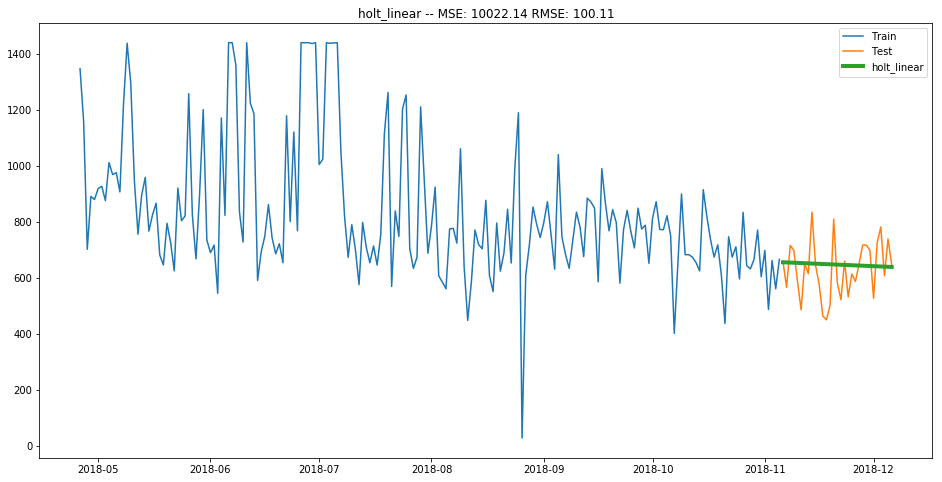

In [31]:
holt_linear('minutes_sedentary', .90005, .00095)

minutes_lightly_active
Holt Linear Trend


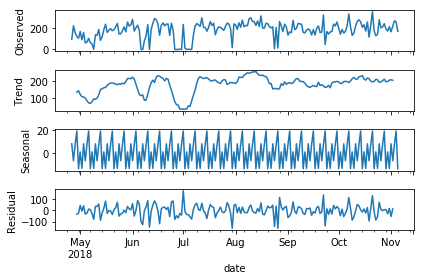

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


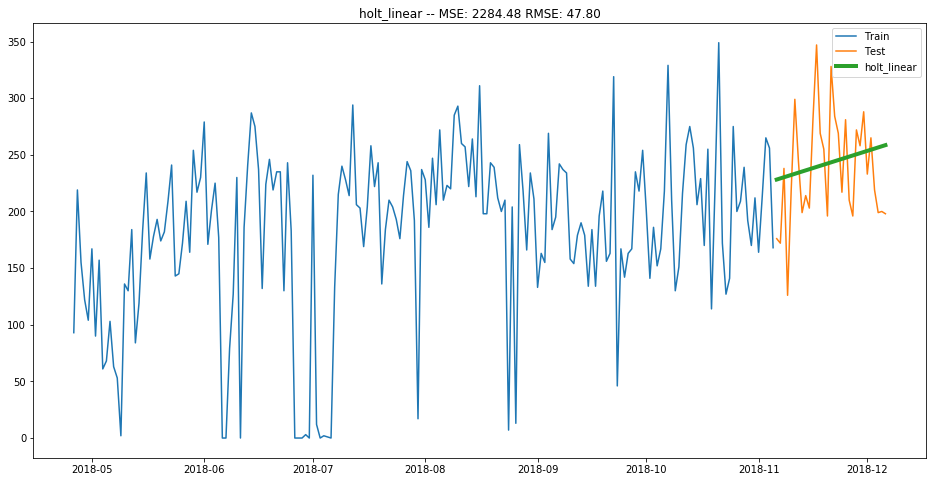

In [32]:
holt_linear('minutes_lightly_active', .35, .65)

minutes_fairly_active
Holt Linear Trend


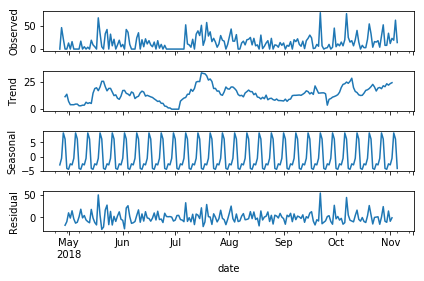

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


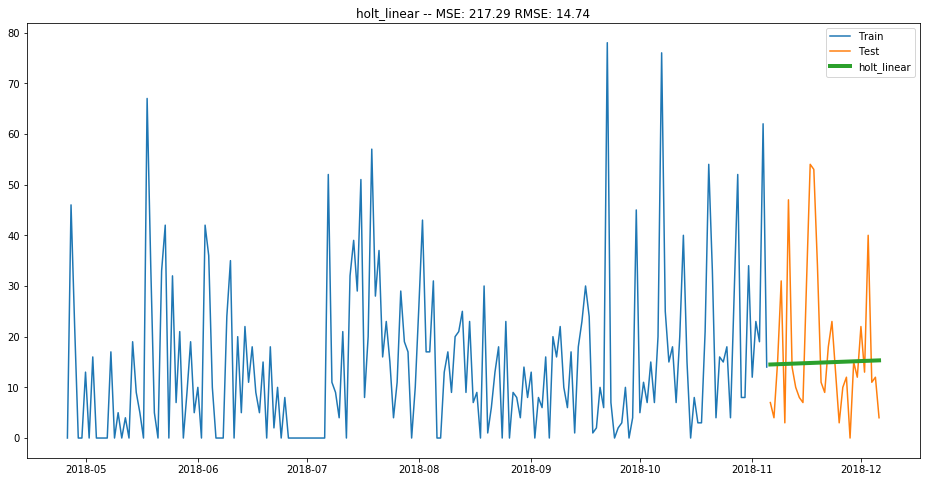

In [33]:
holt_linear('minutes_fairly_active', .99, .01)

minutes_very_active
Holt Linear Trend


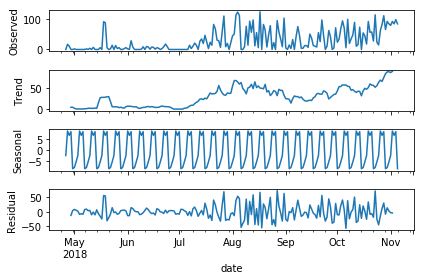

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


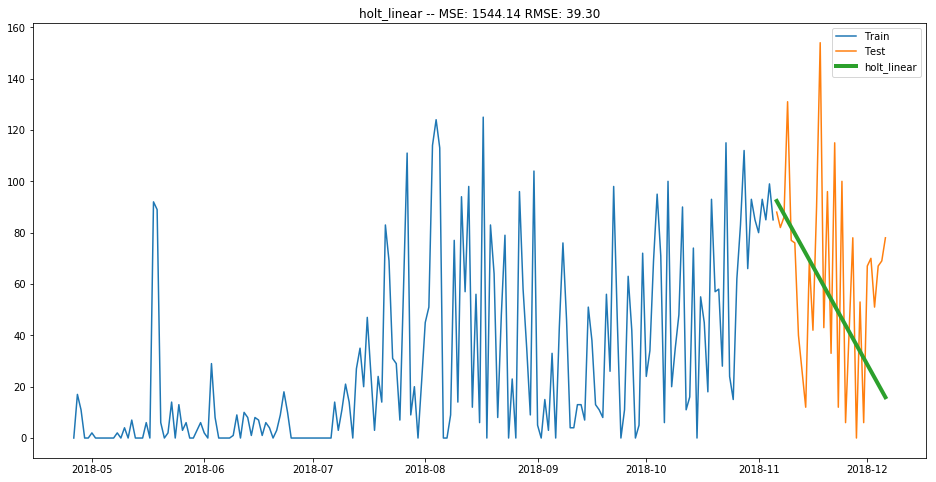

In [34]:
holt_linear('minutes_very_active', .25, .75)

activity_calories
Holt Linear Trend


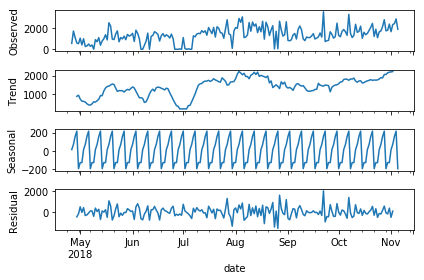

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


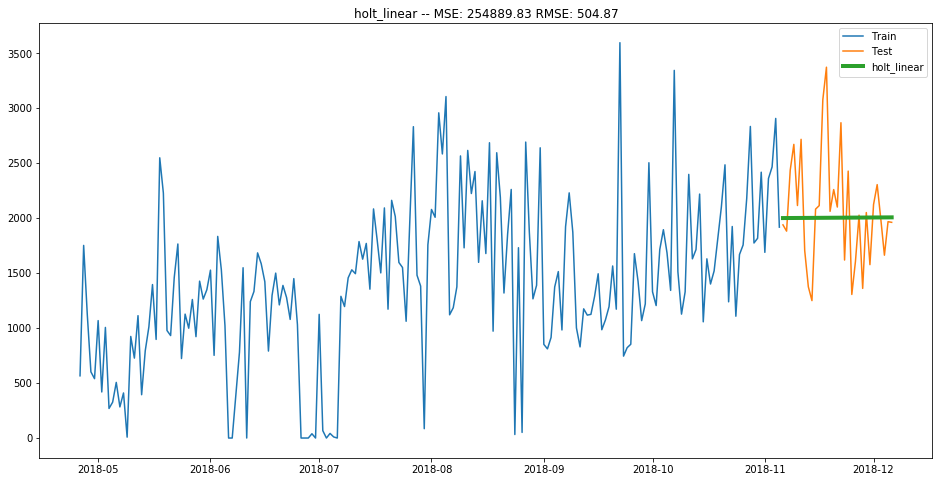

In [35]:
holt_linear('activity_calories', .92, .08)

##### Taking a look at all the RMSE's and MSE's

In [36]:
holt_error = pd.DataFrame(holt_error).set_index(columns)
holt_error

holt mse    holt rmse
calories_burned         1.929520e+05   439.262988
steps                   1.404869e+07  3748.157805
distance                3.360212e+00     1.833088
floors                  2.146537e+03    46.330737
minutes_sedentary       1.002214e+04   100.110634
minutes_lightly_active  2.284482e+03    47.796258
minutes_fairly_active   2.172922e+02    14.740833
minutes_very_active     1.544136e+03    39.295497
activity_calories       2.548898e+05   504.866147

### Key Takeaway from modeling
- prophet model works best for several of the variables
- rolling averages and holt models work well for the other variables
    - rolling average of 1 day or 30 days
- just using last 31 days isn't that great
    - doesn't account for upward trend and some periods of time are different from others

### Getting rid of outliers
Dropping the rows where steps are less than 1000. This also gets rid of rows where hours awake is 24 and all activity was zero. The individual probably didn't wear their fitbit that day. There are still days where a whole day is spent sedentarily, but activity is accounted for. These days, the fitbit was probably worn only for workouts. The sedentary minutes value in these columns is changed to the mean to give a more accurate value.

In [37]:
no_outliers = fitbit[fitbit.steps > 1000]

no_outliers.loc[no_outliers.hours_awake == 24, 'minutes_sedentary'] = no_outliers.minutes_sedentary.mean()

no_outliers['total_minutes'] = no_outliers.minutes_sedentary + no_outliers.minutes_fairly_active +\
                          no_outliers.minutes_lightly_active + no_outliers.minutes_very_active

no_outliers['hours_awake'] = no_outliers.total_minutes/60
no_outliers['hours_asleep'] = 24 - no_outliers.hours_awake

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

### Performing simple average and rolling average on data without outliers.
The MSE's and RMSE's aren't really affected much the removal of outliers. This is likely due to outliers being few in number as well as being out of range of the periods we set for rolling average.



Train/Test plot


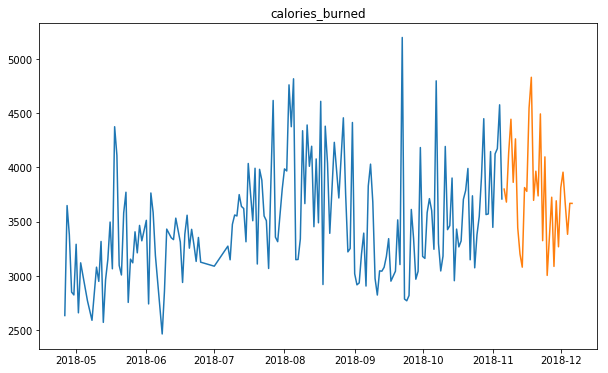



Simple Average


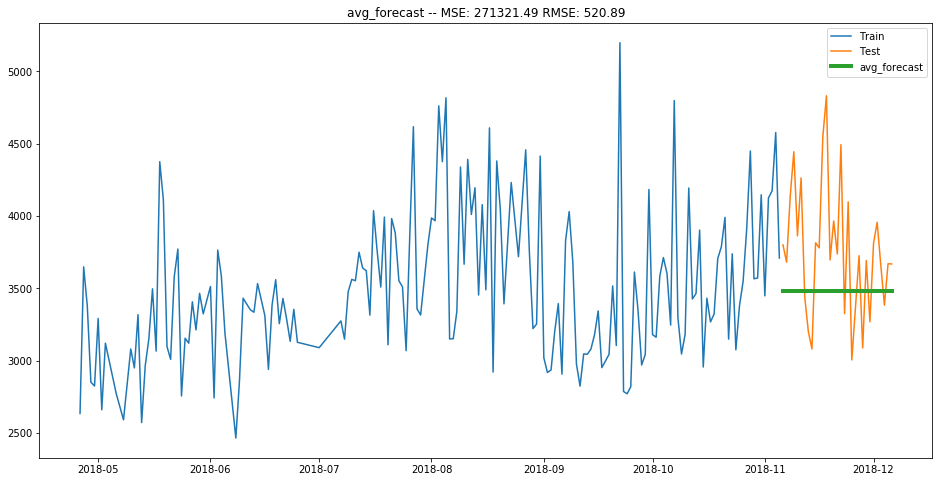



Rolling Average


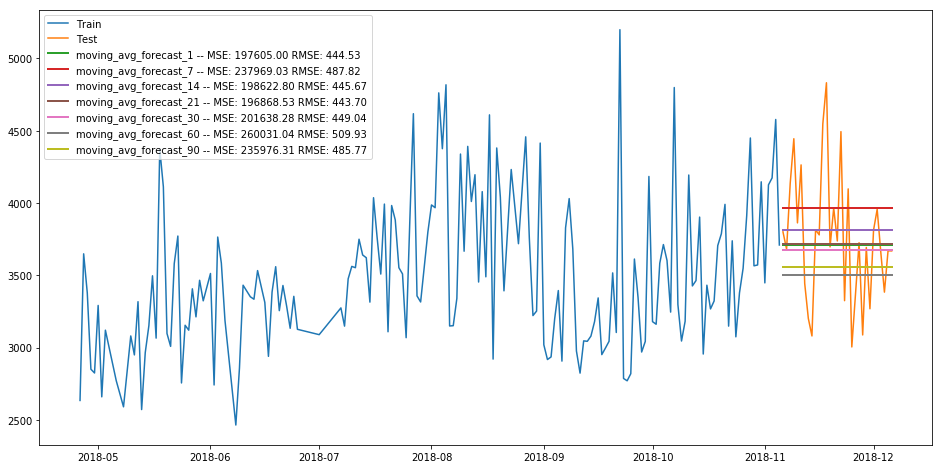



Train/Test plot


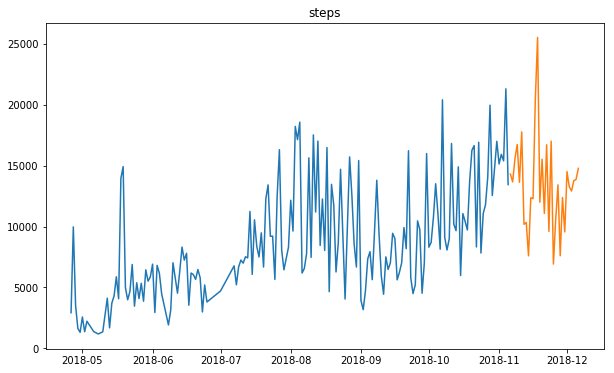



Simple Average


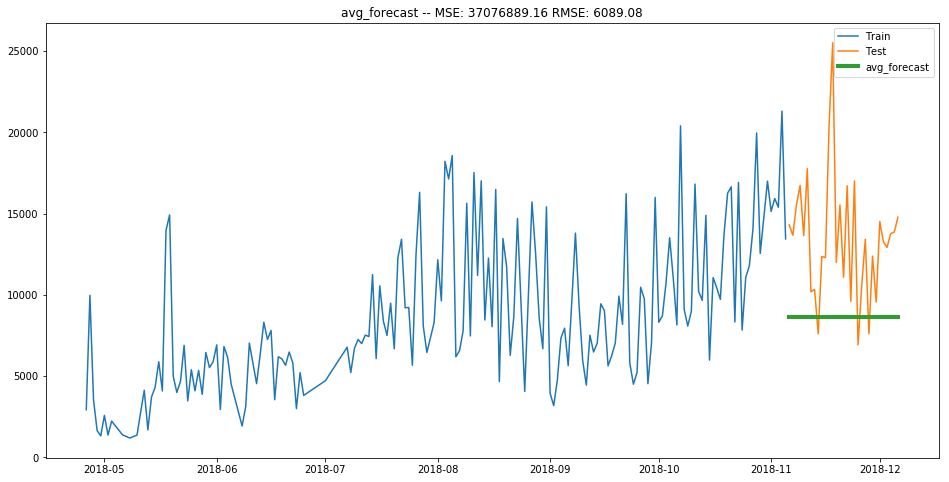



Rolling Average


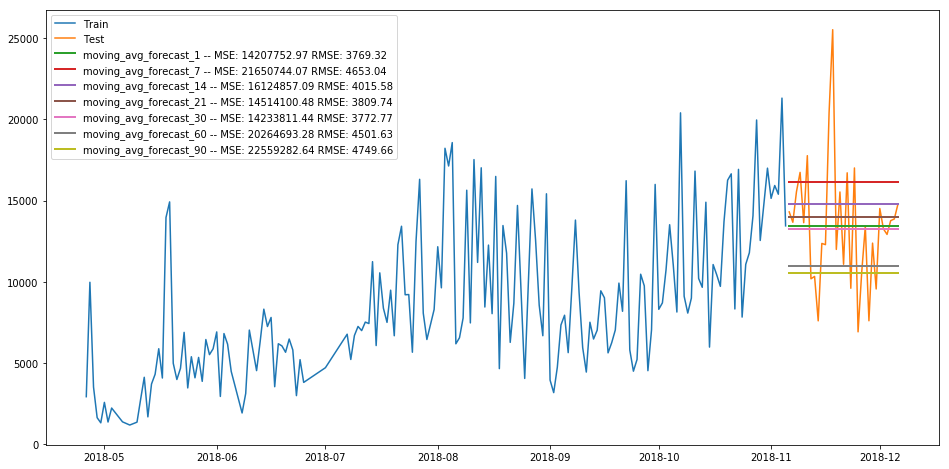



Train/Test plot


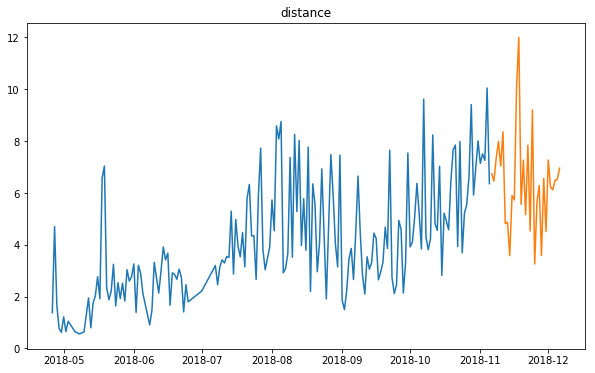



Simple Average


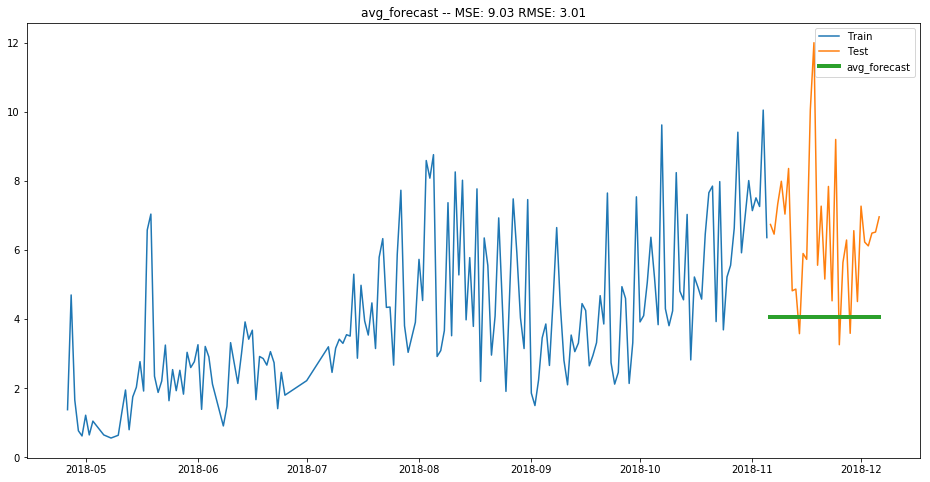



Rolling Average


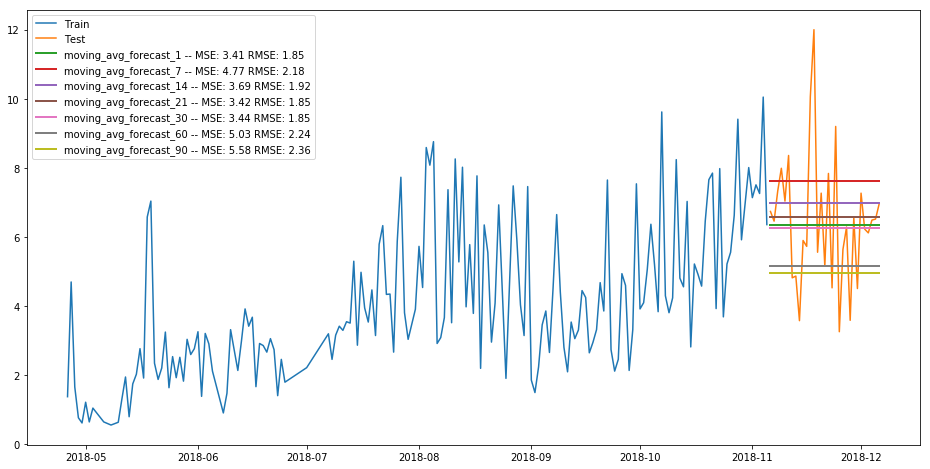



Train/Test plot


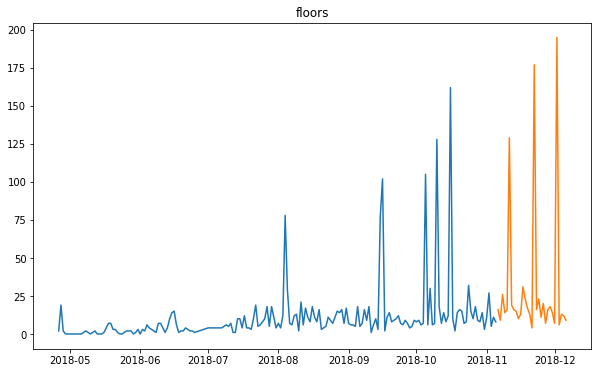



Simple Average


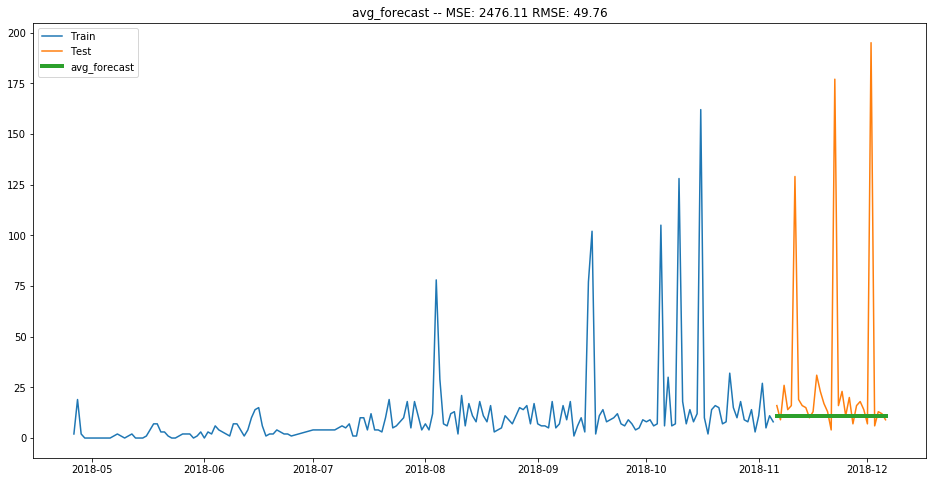



Rolling Average


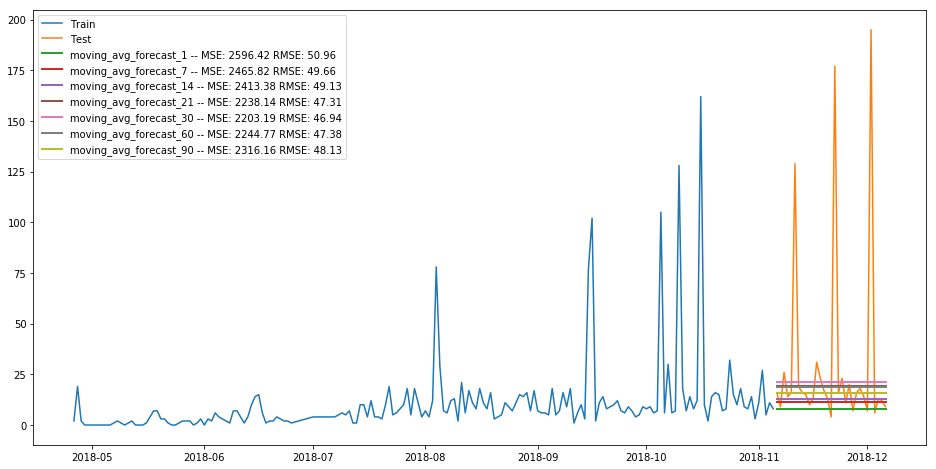



Train/Test plot


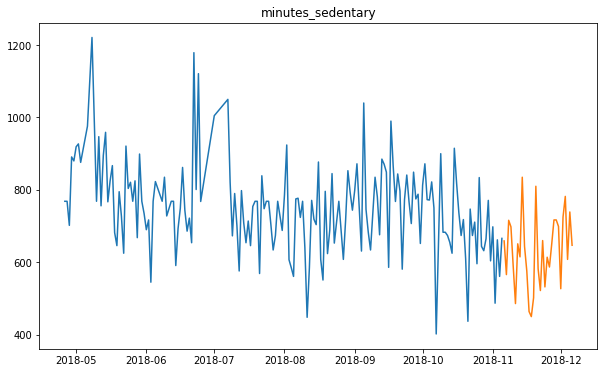



Simple Average


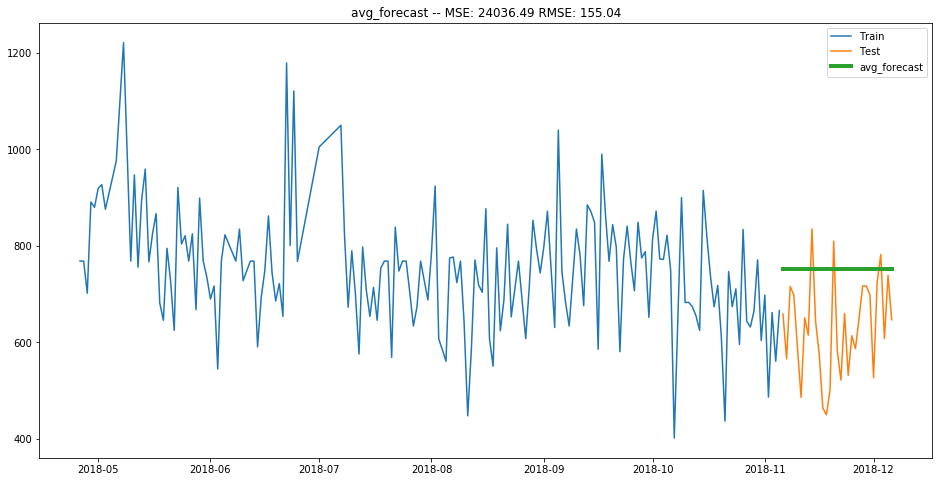



Rolling Average


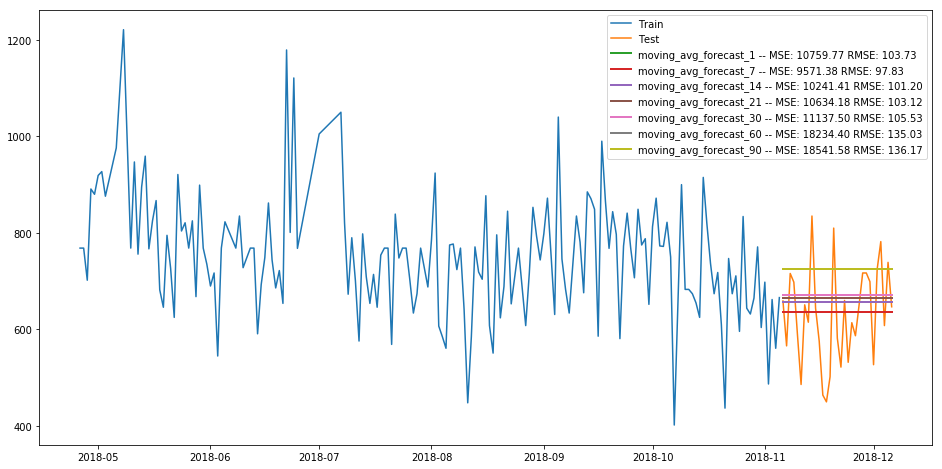



Train/Test plot


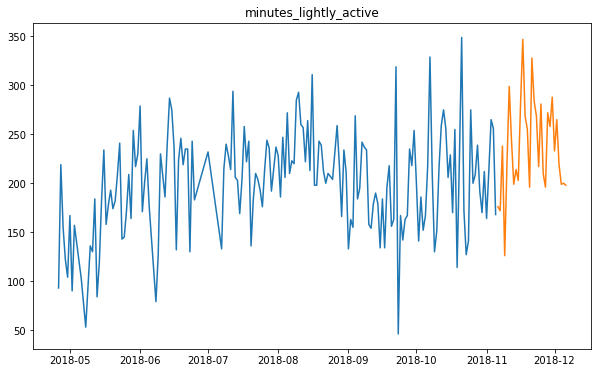



Simple Average


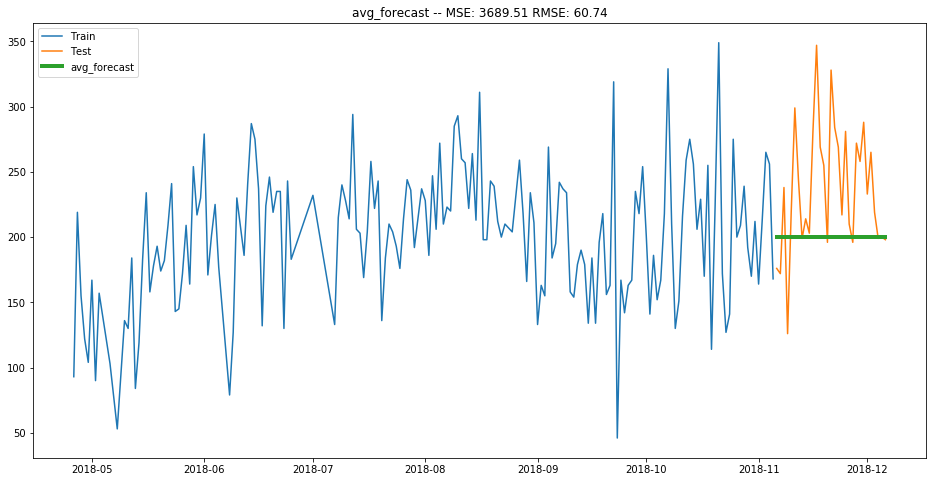



Rolling Average


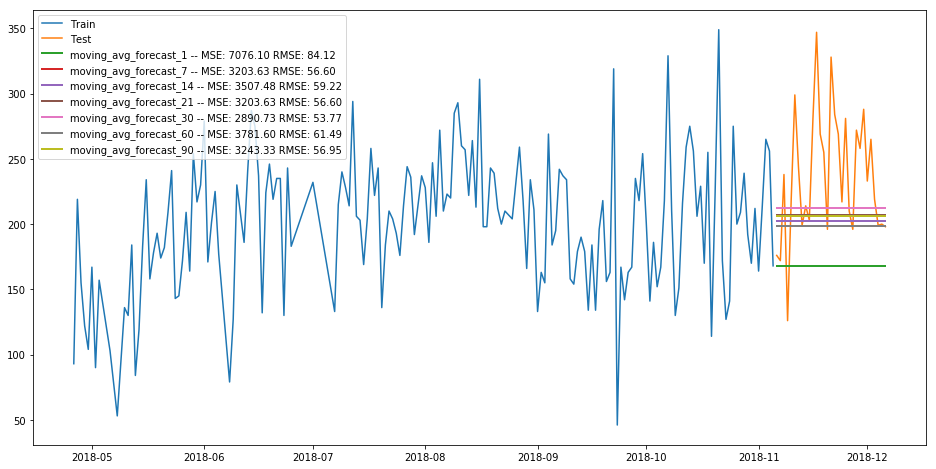



Train/Test plot


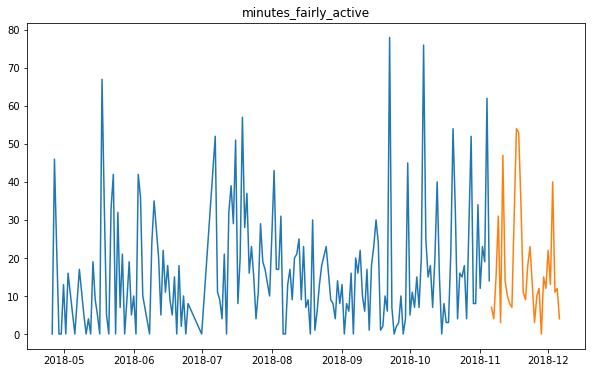



Simple Average


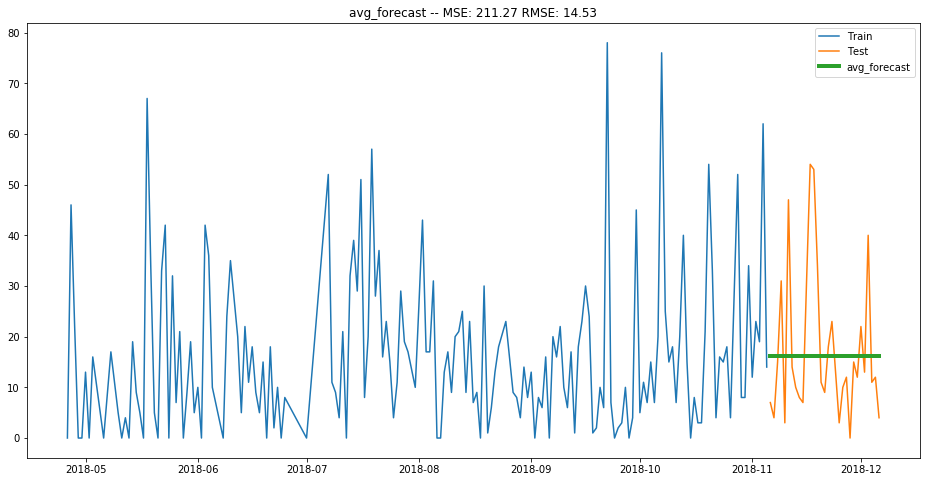



Rolling Average


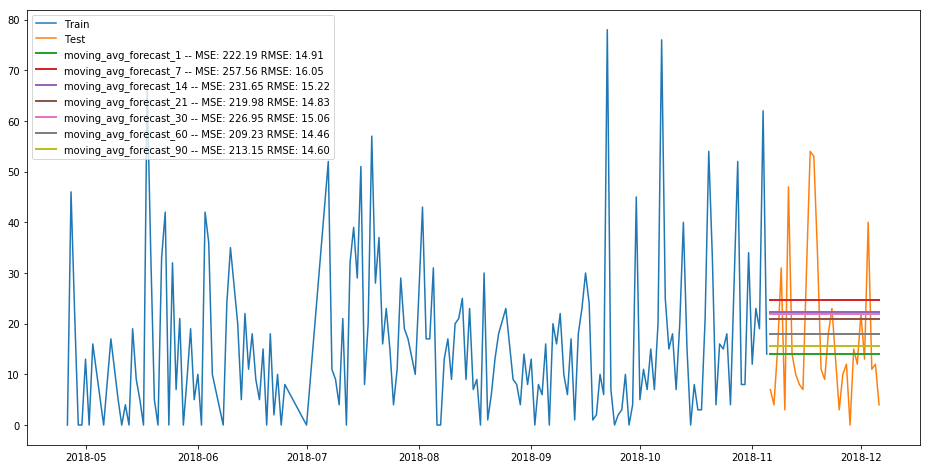



Train/Test plot


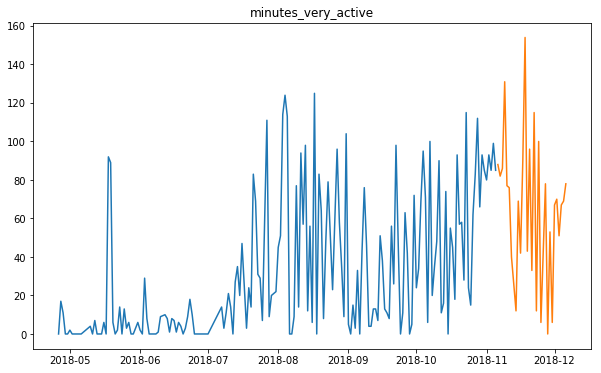



Simple Average


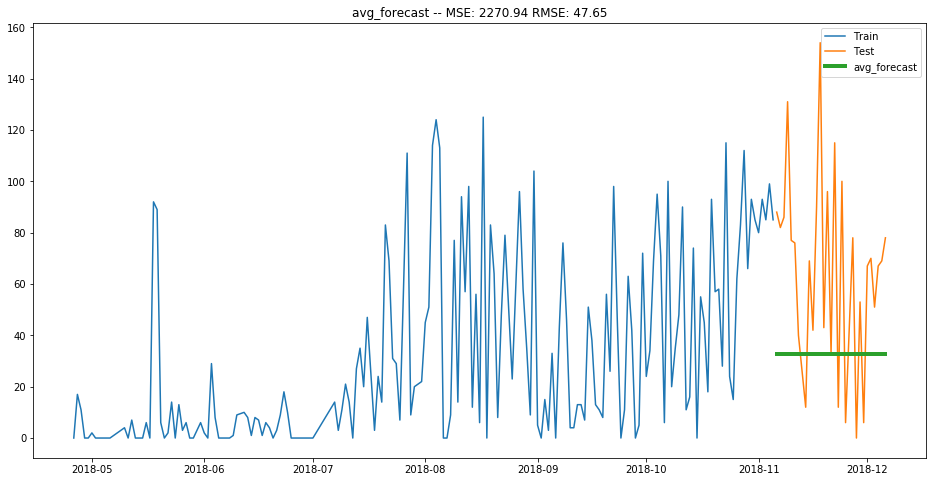



Rolling Average


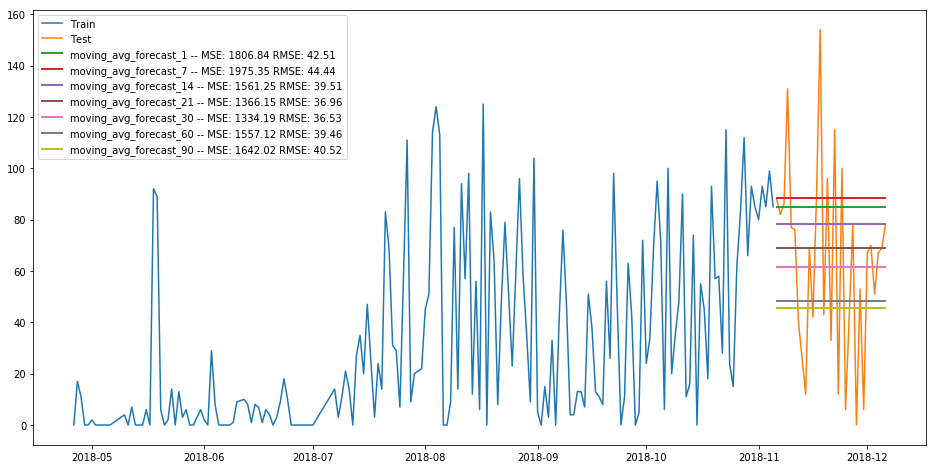



Train/Test plot


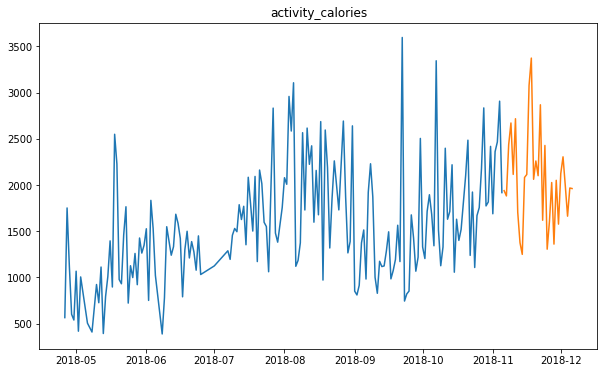



Simple Average


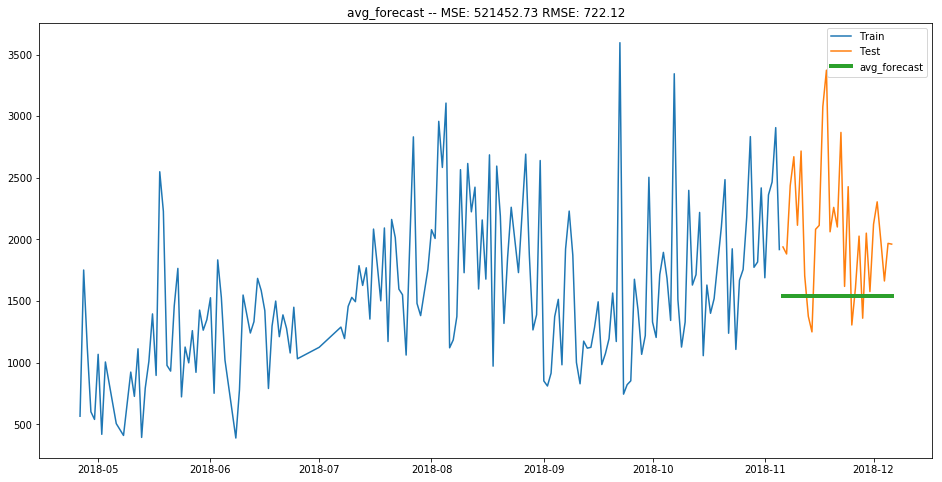



Rolling Average


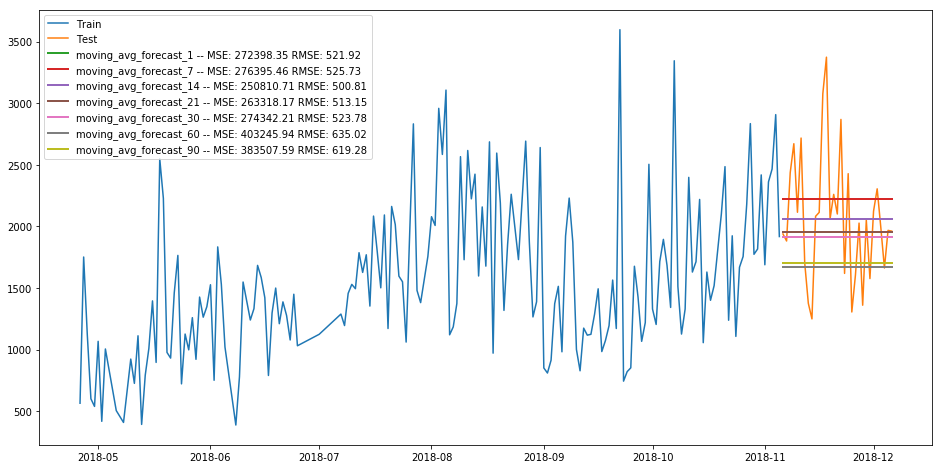

simple average mse  simple average rmse  \
calories_burned               2.713215e+05           520.885292   
steps                         3.707689e+07          6089.079501   
distance                      9.034474e+00             3.005740   
floors                        2.476110e+03            49.760524   
minutes_sedentary             2.403649e+04           155.037045   
minutes_lightly_active        3.689507e+03            60.741316   
minutes_fairly_active         2.112655e+02            14.534974   
minutes_very_active           2.270943e+03            47.654415   
activity_calories             5.214527e+05           722.116837   

                        rolling average mse  rolling average rmse  
calories_burned                2.359763e+05            485.773927  
steps                          2.255928e+07           4749.661318  
distance                       5.583044e+00              2.362847  
floors                         2.316161e+03             48.126513  
minutes_sedentary              1.854158e+04            136.167459  
minutes_lightly_active         3.243331e+03             56.950247  
minutes_fairly_active          2.131477e+02             14.599577  
minutes_very_active            1.642024e+03             40.521899  
activity_calories              3.835076e+05            619.279899

In [38]:
error_dict = {'simple average mse':[], 'simple average rmse':[], 
              'rolling average mse':[], 'rolling average rmse':[]}
for col in columns:
    train = no_outliers[col][:174]
    test = no_outliers[col][174:]

    print('\n')
    print(f'Train/Test plot')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train)
    plt.plot(test)
    plt.title(col)
    plt.show()
    
    yhat = pd.DataFrame(dict(actual=test))
    yhat['avg_forecast'] = train.mean()
    yhat.head()
    
    
    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
            mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
            if len(predictions) > 1:
                label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

        if len(predictions) == 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()
        return mse, rmse
    
    print('\n')
    print(f'Simple Average')
    
    model = 'simple average'
    mse, rmse = plot_and_eval(yhat.avg_forecast)
    error_dict['simple average mse'].append(mse)
    error_dict['simple average rmse'].append(rmse)
    
    print('\n')
    print(f'Rolling Average')
    
    period_vals = [1, 7, 14, 21, 30, 60, 90]

    for periods in period_vals:
        yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

    forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

    model = 'rolling average'
    mse, rmse = plot_and_eval(forecasts, linewidth=2)
    error_dict['rolling average mse'].append(mse)
    error_dict['rolling average rmse'].append(rmse)
    
error_df = pd.DataFrame(error_dict)
return error_df.set_index(columns)

### Removing outliers actually resulted in higher MSE's.
We will be keeping the outliers in the data since they help make better predictions. Minutes sedentary is the exception to that. 

### Making predictions

In [39]:
def holt_linear(col, smoothing_level, smoothing_slope):
    print(col)
    train = fitbit[col][:194]
    test = fitbit[col][194:]

    
    yhat['avg_forecast'] = train.mean()
    yhat.head()

    def plot_data_and_predictions(predictions, label):
        plt.figure(figsize=(10, 8))

        plt.plot(train,label='Train')
        plt.plot(test, label='Test')
        plt.plot(predictions, label=label, linewidth=5)

        plt.legend(loc='best')
        plt.show()


    def evaluate(actual, predictions, output=True):
        mse = metrics.mean_squared_error(actual, predictions)
        rmse = math.sqrt(mse)

        if output:
            print('MSE:  {}'.format(mse))
            print('RMSE: {}'.format(rmse))
        else:
            return mse, rmse    

    def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
        if type(predictions) is not list:
            predictions = [predictions]

        plt.figure(figsize=(16, 8))
        plt.plot(train,label='Train')
        plt.plot(test, label='Test')

        for yhat in predictions:
#             mse, rmse = evaluate(actual, yhat, output=False)        
            label = f'{yhat.name}'
#             if len(predictions) > 1:
#                 label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.plot(yhat, label=label, linewidth=linewidth)

#         if len(predictions) == 1:
#             label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
            plt.title(label)

        plt.legend(loc='best')
        plt.show()    

    print(f'Holt Linear Trend')

    sm.tsa.seasonal_decompose(train).plot()
    result = sm.tsa.stattools.adfuller(train)
    plt.show()

    holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)

    yhat['holt_linear'] = holt.forecast(test.shape[0])

    plot_and_eval(yhat.holt_linear)
#     holt_error['holt mse'].append(mse)
#     holt_error['holt rmse'].append(rmse)
    return holt


steps
Holt Linear Trend


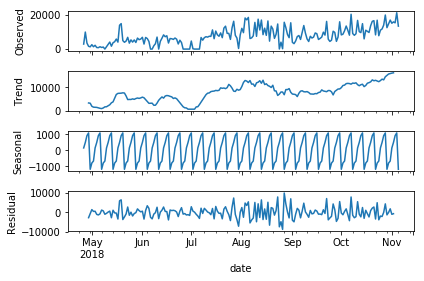

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


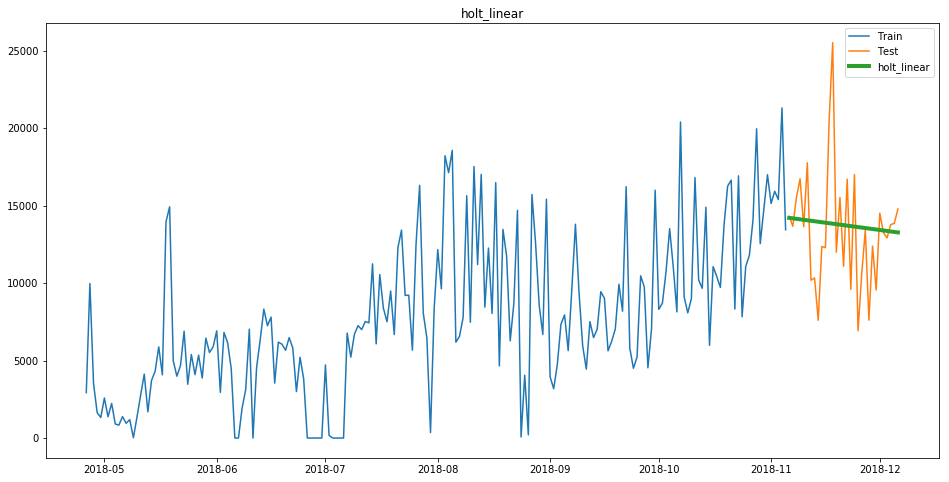

In [40]:
holt = holt_linear('steps', .9, .1)

### Steps Predictions

In [41]:
holt.forecast(fitbit.steps[194:].shape[0]).reset_index()[-22:]

index             0
31 2018-12-07  13237.307165
32 2018-12-08  13205.998551
33 2018-12-09  13174.689936
34 2018-12-10  13143.381322
35 2018-12-11  13112.072707
36 2018-12-12  13080.764093
37 2018-12-13  13049.455478
38 2018-12-14  13018.146864
39 2018-12-15  12986.838249
40 2018-12-16  12955.529635
41 2018-12-17  12924.221020
42 2018-12-18  12892.912406
43 2018-12-19  12861.603791
44 2018-12-20  12830.295177
45 2018-12-21  12798.986562
46 2018-12-22  12767.677948
47 2018-12-23  12736.369333
48 2018-12-24  12705.060719
49 2018-12-25  12673.752105
50 2018-12-26  12642.443490
51 2018-12-27  12611.134876
52 2018-12-28  12579.826261

floors
Holt Linear Trend


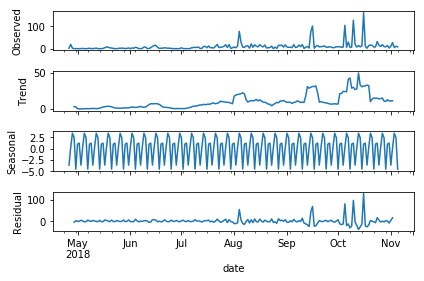

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


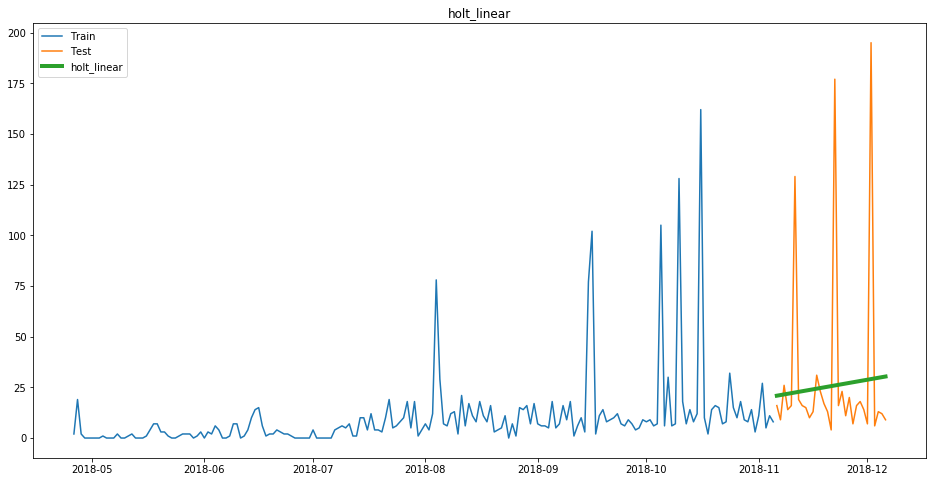

In [42]:
holt = holt_linear('floors', .095, .905)

### Floors Predictions

In [60]:
floors = holt.forecast(fitbit.floors[194:].shape[0])[-22:]
floors

2018-12-07    30.662556
2018-12-08    30.978146
2018-12-09    31.293735
2018-12-10    31.609325
2018-12-11    31.924915
2018-12-12    32.240505
2018-12-13    32.556095
2018-12-14    32.871684
2018-12-15    33.187274
2018-12-16    33.502864
2018-12-17    33.818454
2018-12-18    34.134044
2018-12-19    34.449633
2018-12-20    34.765223
2018-12-21    35.080813
2018-12-22    35.396403
2018-12-23    35.711993
2018-12-24    36.027582
2018-12-25    36.343172
2018-12-26    36.658762
2018-12-27    36.974352
2018-12-28    37.289942
Freq: D, dtype: float64

##### Minutes Fairly Active Predictions

In [44]:
col = 'minutes_fairly_active'
train = fitbit[col][:225]

train.rolling(60).mean().iloc[-1]

18.75

##### Minutes Very Active Predictions

In [50]:
col = 'minutes_very_active'
train = fitbit[col][:225]

train.rolling(30).mean().iloc[-1]

62.36666666666667

In [51]:
def create_feature_frame_prophet(df, feat, periods):
        variable = df[feat]
        train = variable[:194]
        test = variable[194:225]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)
        
        forecast_df1 = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)
        forecast_df1 = forecast_df1[['ds', 'yhat']]
        
        forecast_df1.rename(index=str, columns={'ds':'date'}, inplace=True)
        forecast_df1.rename(index=str, columns={'yhat': str(feat)+'_pred'}, inplace=True)
        
        
        return forecast_df1

In [52]:
calories = create_feature_frame_prophet(fitbit, 'calories_burned', 53)
calories.head(3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  calories_burned_pred
225 2018-12-07           3983.859160
226 2018-12-08           4030.461224
227 2018-12-09           4037.223329

In [53]:
dist = create_feature_frame_prophet(fitbit, 'distance', 53)
dist.head(3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  distance_pred
225 2018-12-07       7.874745
226 2018-12-08       7.963970
227 2018-12-09       8.194519

In [54]:
min_sed = create_feature_frame_prophet(fitbit, 'minutes_sedentary', 53)
min_sed.head(3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  minutes_sedentary_pred
225 2018-12-07              606.207999
226 2018-12-08              508.044440
227 2018-12-09              464.914257

In [56]:
def create_feature_frame_prophet_no_outliers(df, feat, periods):
        variable = df[feat]
        train = variable[:174]
        test = variable[144:205]
        to_predict = variable[225:]
        train_df = train.to_frame()
        train_df.reset_index(inplace=True)
        train_df.rename(index=str, columns={'date':'ds'}, inplace=True)
        train_df.rename(index=str, columns={feat:'y'}, inplace=True)

        train_df['cap'] = max(df[feat])
        train_df['floor'] = min(df[feat])

        m = Prophet(growth='logistic', changepoint_range=0.9)
        m.fit(train_df)

        future = m.make_future_dataframe(periods=periods)
        future['cap'] = max(df[feat])
        future['floor'] = min(df[feat])

        forecast = m.predict(future)
        forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)
        
        forecast_df1 = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)
        forecast_df1 = forecast_df1[['ds', 'yhat']]
        
        forecast_df1.rename(index=str, columns={'ds':'date'}, inplace=True)
        forecast_df1.rename(index=str, columns={'yhat': str(feat)+'_pred'}, inplace=True)
        
        return forecast_df1

In [57]:
lightly = create_feature_frame_prophet_no_outliers(no_outliers, 'minutes_lightly_active', 53)
lightly.head(3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  minutes_lightly_active_pred
205 2018-12-07                   237.588783
206 2018-12-08                   236.391378
207 2018-12-09                   244.111443

In [58]:
act_cal = create_feature_frame_prophet_no_outliers(no_outliers, 'activity_calories', 53)
act_cal.head(3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


date  activity_calories_pred
205 2018-12-07             2359.482756
206 2018-12-08             2308.240308
207 2018-12-09             2366.143009

In [59]:
final = pd.merge(calories, dist, how='inner', on='date')
final = pd.merge(final, min_sed, how='inner', on='date')
final = pd.merge(final, lightly, how='inner', on='date')
final = pd.merge(final, act_cal, how='inner', on='date')
final.head(3)

date  calories_burned_pred  distance_pred  minutes_sedentary_pred  \
0 2018-12-07           3983.859160       7.874745              606.207999   
1 2018-12-08           4030.461224       7.963970              508.044440   
2 2018-12-09           4037.223329       8.194519              464.914257   

   minutes_lightly_active_pred  activity_calories_pred  
0                   237.588783             2359.482756  
1                   236.391378             2308.240308  
2                   244.111443             2366.143009

In [ ]:
matt_final = holt.forecast(fitbit.floors[194:].shape[0])[-22:]
matt_final = matt_final.to_frame()
matt_final.reset_index(inplace=True)
matt_final.rename(index=str, columns={'index':'date'}, inplace=True)
final = pd.merge(matt_final, final, how='inner', on='date')
final.rename(index=str, columns={0:'floors_pred'}, inplace=True)
final

In [62]:
matt_final = holt.forecast(fitbit.steps[194:].shape[0])[-22:]
matt_final = matt_final.to_frame()
matt_final.reset_index(inplace=True)
matt_final.rename(index=str, columns={'index':'date'}, inplace=True)
final = pd.merge(matt_final, final, how='inner', on='date')
final.rename(index=str, columns={0:'steps_pred'}, inplace=True)
final

date  steps_pred  floors_pred  calories_burned_pred  distance_pred  \
0  2018-12-07   30.662556    30.662556           3983.859160       7.874745   
1  2018-12-08   30.978146    30.978146           4030.461224       7.963970   
2  2018-12-09   31.293735    31.293735           4037.223329       8.194519   
3  2018-12-10   31.609325    31.609325           3752.237891       7.037951   
4  2018-12-11   31.924915    31.924915           3812.997742       7.223378   
5  2018-12-12   32.240505    32.240505           3802.831293       7.323177   
6  2018-12-13   32.556095    32.556095           3911.532920       7.779967   
7  2018-12-14   32.871684    32.871684           4010.638041       8.091265   
8  2018-12-15   33.187274    33.187274           4057.193764       8.179823   
9  2018-12-16   33.502864    33.502864           4063.909415       8.409696   
10 2018-12-17   33.818454    33.818454           3778.877410       7.252441   
11 2018-12-18   34.134044    34.134044           3839.590582       7.437172   
12 2018-12-19   34.449633    34.449633           3829.377344       7.536264   
13 2018-12-20   34.765223    34.765223           3938.032073       7.992338   
14 2018-12-21   35.080813    35.080813           4037.090188       8.302911   
15 2018-12-22   35.396403    35.396403           4083.598799       8.390734   
16 2018-12-23   35.711993    35.711993           4090.267232       8.619862   
17 2018-12-24   36.027582    36.027582           3805.187904       7.461854   
18 2018-12-25   36.343172    36.343172           3865.853650       7.645822   
19 2018-12-26   36.658762    36.658762           3855.592885       7.744143   
20 2018-12-27   36.974352    36.974352           3964.199986       8.199438   
21 2018-12-28   37.289942    37.289942           4063.210374       8.509222   

    minutes_sedentary_pred  minutes_lightly_active_pred  \
0               606.207999                   237.588783   
1               508.044440                   236.391378   
2               464.914257                   244.111443   
3               558.129118                   224.134770   
4               593.745579                   231.623709   
5               649.426646                   230.506736   
6               612.740159                   244.866214   
7               592.403318                   239.335549   
8               494.258864                   238.136589   
9               451.147987                   245.855090   
10              544.382352                   225.876844   
11              580.018516                   233.364203   
12              635.719481                   232.245641   
13              599.053089                   246.603520   
14              578.736537                   241.071248   
15              480.612564                   239.870673   
16              437.522360                   247.587550   
17              530.777589                   227.607672   
18              566.434804                   235.093390   
19              622.157010                   233.973179   
20              585.512043                   248.329401   
21              565.217103                   242.795463   

    activity_calories_pred  
0              2359.482756  
1              2308.240308  
2              2366.143009  
3              2018.647536  
4              2022.787120  
5              2113.939215  
6              2228.676053  
7              2397.562781  
8              2346.285005  
9              2404.151519  
10             2056.619007  
11             2060.720702  
12             2151.834060  
13             2266.531320  
14             2435.377629  
15             2384.058598  
16             2441.883026  
17             2094.307600  
18             2098.365556  
19             2189.434355  
20             2304.086239  
21             2472.886361

In [63]:
final['minutes_fairly_active_pred'] = 18.75
final.head()

date  steps_pred  floors_pred  calories_burned_pred  distance_pred  \
0 2018-12-07   30.662556    30.662556           3983.859160       7.874745   
1 2018-12-08   30.978146    30.978146           4030.461224       7.963970   
2 2018-12-09   31.293735    31.293735           4037.223329       8.194519   
3 2018-12-10   31.609325    31.609325           3752.237891       7.037951   
4 2018-12-11   31.924915    31.924915           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   activity_calories_pred  minutes_fairly_active_pred  
0             2359.482756                       18.75  
1             2308.240308                       18.75  
2             2366.143009                       18.75  
3             2018.647536                       18.75  
4             2022.787120                       18.75

In [64]:
final['dist_pred_reg'] = final['steps_pred'] * 0.00047288 + -.0051139
final.head()

date  steps_pred  floors_pred  calories_burned_pred  distance_pred  \
0 2018-12-07   30.662556    30.662556           3983.859160       7.874745   
1 2018-12-08   30.978146    30.978146           4030.461224       7.963970   
2 2018-12-09   31.293735    31.293735           4037.223329       8.194519   
3 2018-12-10   31.609325    31.609325           3752.237891       7.037951   
4 2018-12-11   31.924915    31.924915           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   activity_calories_pred  minutes_fairly_active_pred  dist_pred_reg  
0             2359.482756                       18.75       0.009386  
1             2308.240308                       18.75       0.009535  
2             2366.143009                       18.75       0.009684  
3             2018.647536                       18.75       0.009834  
4             2022.787120                       18.75       0.009983

In [65]:
final['minutes_very_active_pred'] = 62.37
final.head()

date  steps_pred  floors_pred  calories_burned_pred  distance_pred  \
0 2018-12-07   30.662556    30.662556           3983.859160       7.874745   
1 2018-12-08   30.978146    30.978146           4030.461224       7.963970   
2 2018-12-09   31.293735    31.293735           4037.223329       8.194519   
3 2018-12-10   31.609325    31.609325           3752.237891       7.037951   
4 2018-12-11   31.924915    31.924915           3812.997742       7.223378   

   minutes_sedentary_pred  minutes_lightly_active_pred  \
0              606.207999                   237.588783   
1              508.044440                   236.391378   
2              464.914257                   244.111443   
3              558.129118                   224.134770   
4              593.745579                   231.623709   

   activity_calories_pred  minutes_fairly_active_pred  dist_pred_reg  \
0             2359.482756                       18.75       0.009386   
1             2308.240308                       18.75       0.009535   
2             2366.143009                       18.75       0.009684   
3             2018.647536                       18.75       0.009834   
4             2022.787120                       18.75       0.009983   

   minutes_very_active_pred  
0                     62.37  
1                     62.37  
2                     62.37  
3                     62.37  
4                     62.37

In [66]:
final = final[['date',
 'floors_pred',
 'steps_pred',
 'calories_burned_pred',
 'distance_pred',
 'dist_pred_reg',
 'minutes_sedentary_pred',
 'minutes_lightly_active_pred',
 'minutes_fairly_active_pred',
 'minutes_very_active_pred',
 'activity_calories_pred']]
final.head()

date  floors_pred  steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556   30.662556           3983.859160       7.874745   
1 2018-12-08    30.978146   30.978146           4030.461224       7.963970   
2 2018-12-09    31.293735   31.293735           4037.223329       8.194519   
3 2018-12-10    31.609325   31.609325           3752.237891       7.037951   
4 2018-12-11    31.924915   31.924915           3812.997742       7.223378   

   dist_pred_reg  minutes_sedentary_pred  minutes_lightly_active_pred  \
0       0.009386              606.207999                   237.588783   
1       0.009535              508.044440                   236.391378   
2       0.009684              464.914257                   244.111443   
3       0.009834              558.129118                   224.134770   
4       0.009983              593.745579                   231.623709   

   minutes_fairly_active_pred  minutes_very_active_pred  \
0                       18.75                     62.37   
1                       18.75                     62.37   
2                       18.75                     62.37   
3                       18.75                     62.37   
4                       18.75                     62.37   

   activity_calories_pred  
0             2359.482756  
1             2308.240308  
2             2366.143009  
3             2018.647536  
4             2022.787120

In [67]:
final['activity_calories_pred_reg'] = final['steps_pred'] * 0.1375875 + 324.485
final.head()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


date  floors_pred  steps_pred  calories_burned_pred  distance_pred  \
0 2018-12-07    30.662556   30.662556           3983.859160       7.874745   
1 2018-12-08    30.978146   30.978146           4030.461224       7.963970   
2 2018-12-09    31.293735   31.293735           4037.223329       8.194519   
3 2018-12-10    31.609325   31.609325           3752.237891       7.037951   
4 2018-12-11    31.924915   31.924915           3812.997742       7.223378   

   dist_pred_reg  minutes_sedentary_pred  minutes_lightly_active_pred  \
0       0.009386              606.207999                   237.588783   
1       0.009535              508.044440                   236.391378   
2       0.009684              464.914257                   244.111443   
3       0.009834              558.129118                   224.134770   
4       0.009983              593.745579                   231.623709   

   minutes_fairly_active_pred  minutes_very_active_pred  \
0                       18.75                     62.37   
1                       18.75                     62.37   
2                       18.75                     62.37   
3                       18.75                     62.37   
4                       18.75                     62.37   

   activity_calories_pred  activity_calories_pred_reg  
0             2359.482756                  328.703784  
1             2308.240308                  328.747206  
2             2366.143009                  328.790627  
3             2018.647536                  328.834048  
4             2022.787120                  328.877469

In [68]:
final.to_csv('final.csv', index=False)

In [69]:
preds = pd.read_csv(r'final.csv', index_col='date')
preds

floors_pred  steps_pred  calories_burned_pred  distance_pred  \
date                                                                       
2018-12-07    30.662556   30.662556           3983.859160       7.874745   
2018-12-08    30.978146   30.978146           4030.461224       7.963970   
2018-12-09    31.293735   31.293735           4037.223329       8.194519   
2018-12-10    31.609325   31.609325           3752.237891       7.037951   
2018-12-11    31.924915   31.924915           3812.997742       7.223378   
2018-12-12    32.240505   32.240505           3802.831293       7.323177   
2018-12-13    32.556095   32.556095           3911.532920       7.779967   
2018-12-14    32.871684   32.871684           4010.638041       8.091265   
2018-12-15    33.187274   33.187274           4057.193764       8.179823   
2018-12-16    33.502864   33.502864           4063.909415       8.409696   
2018-12-17    33.818454   33.818454           3778.877410       7.252441   
2018-12-18    34.134044   34.134044           3839.590582       7.437172   
2018-12-19    34.449633   34.449633           3829.377344       7.536264   
2018-12-20    34.765223   34.765223           3938.032073       7.992338   
2018-12-21    35.080813   35.080813           4037.090188       8.302911   
2018-12-22    35.396403   35.396403           4083.598799       8.390734   
2018-12-23    35.711993   35.711993           4090.267232       8.619862   
2018-12-24    36.027582   36.027582           3805.187904       7.461854   
2018-12-25    36.343172   36.343172           3865.853650       7.645822   
2018-12-26    36.658762   36.658762           3855.592885       7.744143   
2018-12-27    36.974352   36.974352           3964.199986       8.199438   
2018-12-28    37.289942   37.289942           4063.210374       8.509222   

            dist_pred_reg  minutes_sedentary_pred  \
date                                                
2018-12-07       0.009386              606.207999   
2018-12-08       0.009535              508.044440   
2018-12-09       0.009684              464.914257   
2018-12-10       0.009834              558.129118   
2018-12-11       0.009983              593.745579   
2018-12-12       0.010132              649.426646   
2018-12-13       0.010281              612.740159   
2018-12-14       0.010430              592.403318   
2018-12-15       0.010580              494.258864   
2018-12-16       0.010729              451.147987   
2018-12-17       0.010878              544.382352   
2018-12-18       0.011027              580.018516   
2018-12-19       0.011177              635.719481   
2018-12-20       0.011326              599.053089   
2018-12-21       0.011475              578.736537   
2018-12-22       0.011624              480.612564   
2018-12-23       0.011774              437.522360   
2018-12-24       0.011923              530.777589   
2018-12-25       0.012072              566.434804   
2018-12-26       0.012221              622.157010   
2018-12-27       0.012371              585.512043   
2018-12-28       0.012520              565.217103   

            minutes_lightly_active_pred  minutes_fairly_active_pred  \
date                                                                  
2018-12-07                   237.588783                       18.75   
2018-12-08                   236.391378                       18.75   
2018-12-09                   244.111443                       18.75   
2018-12-10                   224.134770                       18.75   
2018-12-11                   231.623709                       18.75   
2018-12-12                   230.506736                       18.75   
2018-12-13                   244.866214                       18.75   
2018-12-14                   239.335549                       18.75   
2018-12-15                   238.136589                       18.75   
2018-12-16                   245.855090                       18.75   
2018-12-17                   225.876844                       